In [124]:
############################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
import os.path
from os import path
import seaborn as sns
from scipy import signal
import scipy
import warnings
warnings.filterwarnings('ignore')
from matplotlib.ticker import FormatStrFormatter
import pickle

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)
%config InlineBackend.figure_format = 'retina'

In [125]:
##### READ THE DATA ##########

NOWAVEPEAKDATE =  670
NOWAVEPEAKNUMBER = 2

## 1, -- KDP_nu
KDP_nu_name=["CIR40" ,"CIR50"]
KDP_nu=[1,1.25]

## 2,  --  KDP_w_sat_1  -- -
KDP_w_sat_1_name=["0_33" ,"0_66" ,"1_00"]
KDP_w_sat_1=[0.33, 0.66 ,1.00]

## 3,  --  KDP_w_sat_2  -- -
KDP_w_sat_2_name=["ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov"]
KDP_w_sat_2=[380, 442 ,503]

## 4,  --  KDP_g_1  -- -
KDP_g_1_name=["0_33", "0_66" ,"1_00"]
KDP_g_1=[0.33, 0.66, 1.00]

## 5,  --  KDP_g_2  -- -
KDP_g_2_name=["ABW150Days" ,"ABW180Days"]
KDP_g_2=[150 ,180]

## 6,  --  KDP_c_p  -- -
KDP_c_p_name=["Vaccine_PresentRate", "Vaccine_BestWeekAvg", "Vaccine_TwicePresent"]
KDP_c_p=[1 ,1.5, 2]

KDP_lambda_name=["SD_RA","SD_RAR","SD_RARF"]
KDP_lambda=[0,0.1,0.2]

df_active = pd.read_pickle("df_active")
df_nucleation_total = pd.read_pickle("df_nucleation_total")

df_nucleation_11 = pd.read_pickle("df_nucleation_11")
df_nucleation_18 = pd.read_pickle("df_nucleation_18")
df_nucleation_11 = pd.read_pickle("df_nucleation_11")
df_nucleation_45 = pd.read_pickle("df_nucleation_18")
df_nucleation_60 = pd.read_pickle("df_nucleation_45")
df_nucleation_60plus = pd.read_pickle("df_nucleation_60plus")
df_antibody = pd.read_pickle("df_antibody")
df_Vaccinated = pd.read_pickle("df_Vaccinated")



df_nucleation_11_ratio = pd.read_pickle("df_nucleation_11_ratio")
df_nucleation_18_ratio = pd.read_pickle("df_nucleation_18_ratio")
df_nucleation_11_ratio = pd.read_pickle("df_nucleation_11_ratio")
df_nucleation_45_ratio = pd.read_pickle("df_nucleation_18_ratio")
df_nucleation_60_ratio = pd.read_pickle("df_nucleation_45_ratio")
df_nucleation_60plus_ratio = pd.read_pickle("df_nucleation_60plus_ratio")
df_nucleation_18plus_ratio = pd.read_pickle("df_nucleation_18plus_ratio")
df_nucleation_18minus_ratio = pd.read_pickle("df_nucleation_18minus_ratio")
df_nucleation_18plusFull_ratio = pd.read_pickle("df_nucleation_18plusFull_ratio")

df_actual= pd.read_pickle("df_actual_data")

with open('actual.pkl', 'rb') as f: mynewlist = pickle.load(f)

In [3]:
##### TABLE GENERATOR ######
## @@ AGEWISE Cases Probability Table ##

import statistics
import scipy.stats as st


def TableGenerator_Age(df_active,Col_Param1,Col_Param2,ColHead,RowHead,Row_Param):
    ## list of Parameter

    ## Arrays to Store probabilitites
    waveProbArray             = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    
    MeanRatioPeak          = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    CIMeanRatioPeak   = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    stddevMeanRatioPeak=np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    iqrMeanRatioPeak   = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    minRatioPeak   = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    maxRatioPeak   = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    RatioPeaklowerp=np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    RatioPeakupperp=np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    lowerp=25
    upperp=75
    
    MedianRatioPeak          = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    CIMeanRatioPeakLower  = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    CIMeanRatioPeakUpper  = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    iqrMedianRatioPeak   = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    
    KDP_lambda_name=["SD_RA","SD_RAR","SD_RARF"]
    

    
    for i in range(len(Row_Param)):
        
        ## Filter for Both Rows and SubRows
        df_heat_Row_m =  Row_Param[i].copy(deep=True)
        
        df_heat_Row = df_heat_Row_m[df_heat_Row_m["SD"] == KDP_lambda_name[i%3]]
#         df_heat_Row=  Row_Param[i].copy(deep=True)
        
        for j in range(len(Col_Param1)):
            
            ## Filter for j - First Parameeter - Vaccine Rate
            df_heat_col1 = df_heat_Row[df_heat_Row["Vaccine Rate"] == Col_Param1[j]]
            df_heat1     = df_heat_col1[df_heat_col1["KDPwsat2"] == Col_Param2[j]]
            
            totalCases = df_heat1.shape[0]
            
            ## remove no wave scenarios
            df_heat2 = df_heat1[df_heat1["Date Of Peak"] != NOWAVEPEAKDATE].copy(deep=True)
            wave3Cases    = df_heat2.shape[0]
            if(wave3Cases):

                ratioWave3    = wave3Cases/totalCases
                waveProbArray[i][j] = ratioWave3
                
                wave2List = df_heat2[324]
                Wave3List = df_heat2['Number At Peak'].copy(deep = True)
                RatioList = Wave3List.div(wave2List)
                
                
                #### MEDIAN NUMBER AT PEAK  
                MedianRatioPeak[i][j] = np.median(RatioList)
                RatioPeaklowerp[i][j]=np.percentile(RatioList,lowerp)
                RatioPeakupperp[i][j]=np.percentile(RatioList,upperp)
#                 ci_MedianRatioAtPeak=st.t.interval(0.95,wave3Cases-1,loc=np.median(RatioList),scale=scipy.stats.sem(RatioList))
                iqr_MedianRatioAtPeak=st.iqr(RatioList)
                #print(ci_MedianRatioAtPeak)
                #CIMedianRatioPeak[i][j] = abs(  max(ci_MedianRatioAtPeak)  - MedianRatioPeak[i][j] )
                iqrMedianRatioPeak[i][j]=iqr_MedianRatioAtPeak
                min_MedianRatioAtPeak=np.min(RatioList)
                minRatioPeak[i][j]=np.min(RatioList)
                maxRatioPeak[i][j]=np.max(RatioList)
                
                
                ### MEan Ratio at peak
                MeanRatioPeak[i][j] = statistics.mean(RatioList)
                ci_MeanRatioAtPeak=st.t.interval(0.95,wave3Cases-1,loc=np.mean(RatioList),scale=scipy.stats.sem(RatioList))
                iqr_MeanRatioAtPeak=st.iqr(RatioList)
                #print(ci_MedianRatioAtPeak)
                CIMeanRatioPeak[i][j] = abs(  max(ci_MeanRatioAtPeak)  - MeanRatioPeak[i][j] )
                CIMeanRatioPeakLower[i][j]=ci_MeanRatioAtPeak[0]
                CIMeanRatioPeakUpper[i][j]=ci_MeanRatioAtPeak[1]
                iqrMeanRatioPeak[i][j] = iqr_MeanRatioAtPeak
                stddevMeanRatioPeak[i][j]=np.std(RatioList)
                
                            
#             else:
#                 MedianDateAtpeak[i][j] = "No Wave 3"
                

#                 plt.hist(RatioList)
#                 plt.title(str(KDP_lambda_name[i%3])+" "+str(Col_Param1[j])+" "+str(Col_Param2[j]))
#                 plt.show()
    return MedianRatioPeak,RatioPeaklowerp,RatioPeakupperp , RatioList,CIMeanRatioPeak,stddevMeanRatioPeak,CIMeanRatioPeakLower,CIMeanRatioPeakUpper,MeanRatioPeak

list_param1=["ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov","Vaccine_PresentRate", "Vaccine_BestWeekAvg", "Vaccine_TwicePresent","SD_RA","SD_RAR","SD_RARF"]
list_head1=["KDPwsat2","KDPwsat2","KDPwsat2","Vaccine Rate","Vaccine Rate","Vaccine Rate","SD","SD","SD"]
list_label=["IENV-Jul21" ,"IENV-Sep21", "IENV-Nov21","VR-100P", "VR-150P", "VR-200P","SD-Good","SD-Bad","SD-Worse"]

Col_Param2  = ["ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov","ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov","ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov"]
Col_Param1  = ["Vaccine_PresentRate", "Vaccine_PresentRate", "Vaccine_PresentRate", "Vaccine_BestWeekAvg", "Vaccine_BestWeekAvg", "Vaccine_BestWeekAvg","Vaccine_TwicePresent","Vaccine_TwicePresent","Vaccine_TwicePresent", ]
ColHead     = ["KDPwsat2","Vaccine Rate"]

RowHead     = ["SD"]
Row_Param   = [df_nucleation_11,df_nucleation_11,df_nucleation_11,
               df_nucleation_18,df_nucleation_18,df_nucleation_18,
               df_nucleation_45,df_nucleation_45,df_nucleation_45,
               df_nucleation_60,df_nucleation_60,df_nucleation_60,
              df_nucleation_60plus,df_nucleation_60plus,df_nucleation_60plus]
# Row_Param   = [df_nucleation_11,
#                df_nucleation_18,
#                df_nucleation_45,
#                df_nucleation_60,
#               df_nucleation_60plus]
# minRatioPeak,maxRatioPeak,waveProbArray, MedianRatioPeak, CIMedianRatioPeak , MeanRatioPeak , CIMeanRatioPeak,iqrMeanRatioPeak,iqrMedianRatioPeak, RatioList= \
# TableGenerator_Age(df_active,Col_Param1,Col_Param2,ColHead,RowHead,Row_Param)
MedianRatioPeak,RatioPeaklowerp,RatioPeakupperp, RatioList,CIMeanRatioPeak,stddevMeanRatioPeak,CIMeanRatioPeakLower,CIMeanRatioPeakUpper,MeanRatioPeak=TableGenerator_Age(df_active,Col_Param1,Col_Param2,ColHead,RowHead,Row_Param)

In [4]:
### PRINTTER FOR EXCEL ####

def formatter(array):
    ans =  np.zeros(shape=(array.shape[0],array.shape[1]), dtype = object)
    row = array.shape[0]
    col = array.shape[1]
    
    for i in range(row):
        for j in range(col):
            val = array[i][j]
            if(val == 0):
                ans[i][j] = "0"
            elif( int(val / 1000000) >= 1):
                ans[i][j] =  str(int(val/1000000)) + "M"
#                 print (str(int(val/1000000)) + "M")
            elif( int(val / 1000) >= 1):
                ans[i][j] =  str(int(val/1000)) + "K"
#                 print (str(int(val/1000)) + "K")
            else:
                ans[i][j] =  str(int(val))
            
            
        pass;
    return ans;
    pass;

# ans  = formatter(MaxNumAtPeak)
# ans = MedianRatioPeak
ans = CIMeanRatioPeak
for i in range(ans.shape[0]):
    for j in range(ans.shape[1]):
        print("{:.2f}".format(ans[i][j]) ,",",end = '')
    print("\n",end = '')


0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,
0.52 ,0.07 ,0.05 ,0.45 ,0.09 ,0.01 ,0.41 ,0.07 ,0.00 ,
6.66 ,1.68 ,9.95 ,5.89 ,1.22 ,3.67 ,4.84 ,1.08 ,0.85 ,
0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,
0.52 ,0.07 ,0.04 ,0.45 ,0.07 ,0.01 ,0.41 ,0.06 ,0.00 ,
6.73 ,1.58 ,9.62 ,5.80 ,1.13 ,3.38 ,4.82 ,0.95 ,0.76 ,
0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,
0.52 ,0.07 ,0.04 ,0.45 ,0.07 ,0.01 ,0.41 ,0.06 ,0.00 ,
6.73 ,1.58 ,9.62 ,5.80 ,1.13 ,3.38 ,4.82 ,0.95 ,0.76 ,
0.01 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,
0.43 ,0.04 ,0.00 ,0.33 ,0.03 ,0.00 ,0.26 ,0.01 ,0.00 ,
5.50 ,0.90 ,4.61 ,4.18 ,0.50 ,0.99 ,3.21 ,0.32 ,0.11 ,
0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,0.00 ,
0.31 ,0.02 ,0.00 ,0.19 ,0.00 ,0.00 ,0.10 ,0.00 ,0.00 ,
4.02 ,0.43 ,0.85 ,2.62 ,0.11 ,0.00 ,1.63 ,0.00 ,0.00 ,


In [126]:
####### DEFNITION ######################
## @@ Wave Heat Map probability ###


SIZE = 16

plt.rcParams["text.usetex"] = False
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"]
plt.rcParams['xtick.labelsize'] = SIZE
plt.rcParams['ytick.labelsize'] = SIZE
plt.rcParams['xtick.labelsize'] = SIZE
plt.rcParams['ytick.labelsize'] = SIZE
plt.rcParams['axes.labelsize']=SIZE



plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title

import statistics
def HeatPlotDataGenerator(DataFrame,list_param,list_head,list_label):
    ## list of Parameter

    ## Arrays to Store probabilitites
    noWaveProbArray = np.zeros(shape=(len(list_param),len(list_head)))
    waveProbArray = np.zeros(shape=(len(list_param),len(list_head)))
    MedianNumberAtPeak = np.zeros(shape=(len(list_param),len(list_head)))

    # Copt of Dataframe
    df_heat_master = df_active.copy(deep=True)
    
    for i in range(len(list_param)):
        print(" i - " ,  list_label[i] ," " , list_param[i] , " ", list_head[i])
        for j in range(len(list_param)):
            df_heat1 = df_heat_master[(df_heat_master[list_head[i]] == list_param[i]) & (df_heat_master[list_head[j]] == list_param[j]) ]            
            
            totalCases = df_heat1.shape[0]
            
            
            if((list_head[i] == list_head[j]) and (i != j)):
                noWaveProbArray[i][j] = 10;
                waveProbArray[i][j]   = 10;
                MedianNumberAtPeak[i][j] = 50;
            
            if(totalCases):
                ## remove no wave scenarios
                df_heat2 = df_heat1[df_heat1["Date Of Peak"] != NOWAVEPEAKDATE]

                wave3Cases    = df_heat2.shape[0]
                noWave3Cases  = totalCases - wave3Cases

                ratioWave3    = wave3Cases/totalCases
                ratioNoWave3  = noWave3Cases/totalCases

                noWaveProbArray[i][j] = ratioNoWave3
                waveProbArray[i][j]   = ratioWave3
                if(wave3Cases !=0):
                    MedianNumberAtPeak[i][j] = np.log10(statistics.mean(df_heat2["Number At Peak"]))
                
            
    return MedianNumberAtPeak,noWaveProbArray,waveProbArray
    

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):

    if not ax:
        ax = plt.gca()
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    ax.set_facecolor('blue')
    # Create colorbar
    lab=[r"$10^{4}$","",r"$10^{5}$","",r"$10^{6}$",r"$10^{6.5}$"] 
    tick=[4,4.5,5,5.5,6,6.5]
    lab=["0.0","0.2","0.4","0.6","0.8","1.0"] 
    tick=[0,0.2,0.4,0.6,0.8,1.0]
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom",size=SIZE)
    cbar.ax.set_yticks(tick)
    cbar.ax.set_yticklabels(lab,size=SIZE)
    
   


    
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    
        
    
    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    # Turn spines off and create white grid.
    
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="#E5E4E2", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    

    return im, cbar


 i -  Good CAB   SD_RA   SD
 i -  VR-560K   Vaccine_TwicePresent   Vaccine Rate
 i -  IENV-Nov21   ImmunEscp_Nov   KDPwsat2
 i -  IENV-Sep21   ImmunEscp_Sep   KDPwsat2
 i -  VR-280K   Vaccine_PresentRate   Vaccine Rate
 i -  VR-420K   Vaccine_BestWeekAvg   Vaccine Rate
 i -  IENV-Jul21   ImmunEscp_Jul   KDPwsat2
 i -  Partial CAB   SD_RAR   SD
 i -  No CAB   SD_RARF   SD


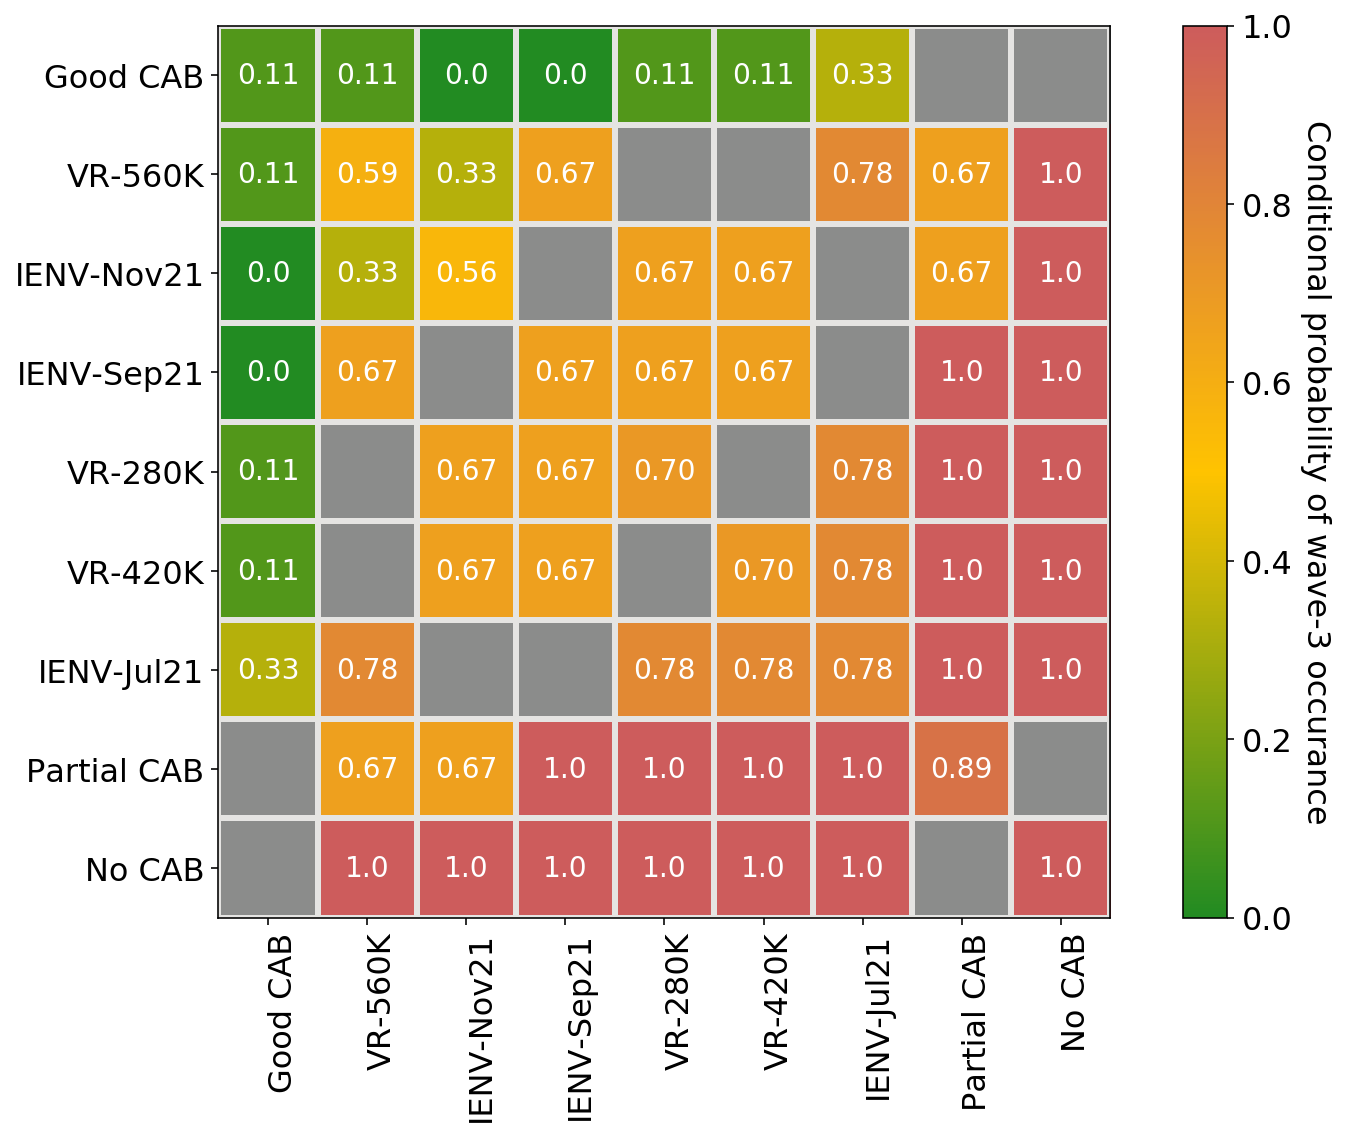

In [128]:
###### PLOTTER SCRIPT #######
## Heat Wave Plotter ######
import matplotlib.colors
%matplotlib inline
def HeatwavePlotter(DataFrame,list_param,list_head,list_label,PlotExtension,BoolProbability,boolNumbers):
    
    numatpeak, noWaveArray,waveArray = HeatPlotDataGenerator(DataFrame,list_param, list_head,list_label)   
    
    fig, ax = plt.subplots(figsize=[11,8])
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#228B22","#FFC300","#CD5C5C"])
    cmap.set_over('#8b8c8b')
#     color_map=plt.cm.get_cmap("autumn")
#     reversed_cmap=cmap.reversed()
    
#     plt.rcParams['axes.facecolor']='white'
    flat=numatpeak.flatten()
    flat.sort()
    flat= np.unique(flat)
    maxVal = flat[-2]
    
    if(not BoolProbability):
        im, cbar = heatmap(numatpeak, list_label, list_label, ax=ax,
                           cmap=cmap, cbarlabel="Median of Active cases at peak",vmin=4, vmax=6.5)
    else:
        im, cbar = heatmap(waveArray, list_label, list_label, ax=ax,
                           cmap=cmap, cbarlabel="Conditional probability of wave-3 occurance",vmin=0, vmax=1)
    
    ax.set_facecolor('blue')

    if(boolNumbers):
        for i in range(len(list_param)):
            for j in range(len(list_head)):
                if(waveArray[i][j] != 10):
                    num = np.round(waveArray[i][j],2)
                    strnum = str(num)
                    strnum = strnum[:4]
                    text = ax.text(i, j, strnum,
                                   ha="center", va="center", color="w",size=SIZE-2)

    fig.tight_layout()
    
#     plt.text(-0.9,-0.9,'(b)',size=SIZE)
    name ="divij_final_heatmap_wave3" + PlotExtension + ".eps"
    plt.savefig(name,dpi=100,bbox_inches='tight')
    plt.show()
    

    


# list_param=["CIR40","CIR50","0_33", "0_66" ,"1_00","ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov","0_33", "0_66" ,"1_00","ABW150Days" ,"ABW180Days","Vaccine_PresentRate", "Vaccine_BestWeekAvg", "Vaccine_TwicePresent","SD_RA","SD_RAR","SD_RARF"]
# list_head=["CIR","CIR","KDPwsat1","KDPwsat1","KDPwsat1","KDPwsat2","KDPwsat2","KDPwsat2","KDPg1","KDPg1","KDPg1","KDPg2","KDPg2","Vaccine Rate","Vaccine Rate","Vaccine Rate","SD","SD","SD"]   
# list_label=["CIR40","CIR50","IENV-33P", "IENV-66P" ,"IENV-100P","IENV-Jul21" ,"IENV-Sep21", "IENV-Nov21","ABW-33P", "ABW-66P" ,"ABW-100P","ABW-150" ,"ABW-180","VR-100P", "VR-150P", "VR200P","SD-Good","SD-Bad","SD-Worse"]


# list_param=["SD_RA", "Vaccine_TwicePresent", "ImmunEscp_Nov","CIR40","CIR50","0_33", "0_66" ,"ImmunEscp_Sep","0_33", "0_66" ,"1_00","ABW150Days" ,"ABW180Days","Vaccine_PresentRate", "Vaccine_BestWeekAvg","1_00","ImmunEscp_Jul" ,"SD_RAR","SD_RARF"]
# list_head=["SD","Vaccine Rate","KDPwsat2","CIR","CIR","KDPwsat1","KDPwsat1","KDPwsat2","KDPg1","KDPg1","KDPg1","KDPg2","KDPg2","Vaccine Rate","Vaccine Rate","KDPwsat1","KDPwsat2","SD","SD"]   
# list_label=["Good CAB",  "VR-560K","IENV-Nov21","CIR40","CIR50","IENV-33P", "IENV-66P" ,"IENV-Sep21","ABW-33P", "ABW-66P" ,"ABW-100P","ABW-150" ,"ABW-180","VR-280K", "VR-560K" ,"IENV-100P","IENV-Jul21","Partial CAB","No CAB"]

list_param=["SD_RA", "Vaccine_TwicePresent", "ImmunEscp_Nov","ImmunEscp_Sep","Vaccine_PresentRate", "Vaccine_BestWeekAvg","ImmunEscp_Jul" ,"SD_RAR","SD_RARF"]
list_head=["SD","Vaccine Rate","KDPwsat2","KDPwsat2","Vaccine Rate","Vaccine Rate","KDPwsat2","SD","SD"]   
list_label=["Good CAB","VR-560K", "IENV-Nov21","IENV-Sep21","VR-280K", "VR-420K","IENV-Jul21","Partial CAB","No CAB"]



HeatwavePlotter(df_active,list_param,list_head,list_label,"ProbCasesAtPeak_Short",True,True)
# HeatwavePlotter(df_active,list_param,list_head,list_label,"ProbCasesAtPeak",True,False)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


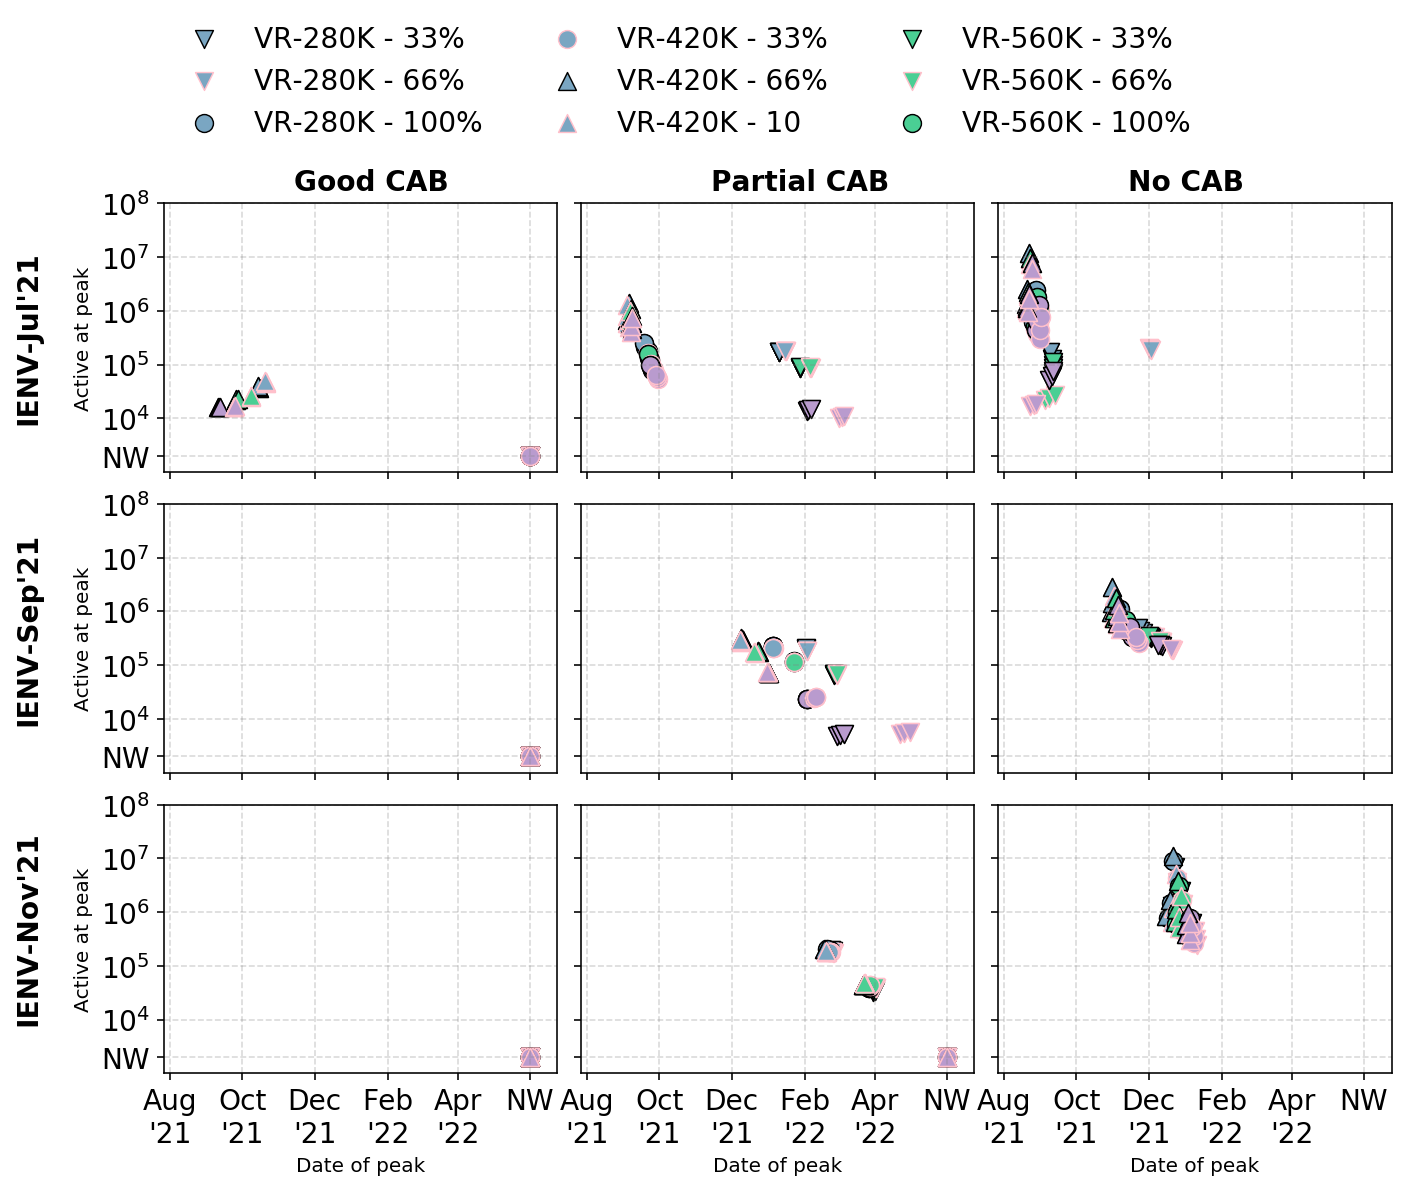

In [7]:
###--- PLOTTER ----     ####
### @@ GROUP SCATTER PLOTTER    ###

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


###################### _____________________GROUP SCATTER PLOTTERS ______________________________ ##############################
        
import warnings
warnings.filterwarnings('ignore')


def SCATTER_plotter_Group(df_active,plotName):
    
    from scipy.stats import norm
    import numpy
    import sklearn
    from sklearn.neighbors import KernelDensity
    from sklearn.utils.fixes import parse_version
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import LeaveOneOut
    from sklearn import preprocessing
    import matplotlib.patches as mpatches
    fig, ax = plt.subplots(3,3,figsize=(11,8),sharex=True,sharey=True)

    ####### -- PLotter Parameters -- ######
    plt.rcParams["text.usetex"] = False
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Computer Modern"]
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14

    SIZE = 14


    plt.rc('font', size=SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE)    # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title

    xtl = []
    xt = [396,457,518,580,639,700]   ## 1st days of the months hardcoded 
    xtl = ['Aug\n\'21','Oct\n\'21','Dec\n\'21','Feb\n\'22','Apr\n\'22','NW']



    ## Set plotting parameters   -- Number at Peak
    markersizep = 1.9
    nTicks_C = 10
    startDay_C = 0
    endDay_C = 4e6
    xt_C = [2000,1e4,1e5,1e6,1e7,1e8]
    xtl_C = ["NW",r"$10^{4}$",r"$10^{5}$",r"$10^{6}$",r"$10^{7}$",r"$10^{8}$"];
    

    #### PLotting Colors and other Parameters 
    edgeColor = ['black','pink']
    alphaVal = [1,0.3]
    colorVal = ['#7aa6c2','#4acf94','#b99bce']
    marker  = ['v','o','^']
    kernel = 'epanechnikov'
    KDPCIR=["CIR 40", "CIR 50"]
    KDPImm = ["IENV-Jul'21","IENV-Sep'21","IENV-Nov'21"]
    Vacc=["VR-280K","VR-420K","VR-560K"]
    KDP_lambda_Array = ["Good CAB" ,"Partial CAB","No CAB"]
    BackGroundColor = ["#ffffff","#ffffff","#ffffff","#ffffff"]
    JitterDate = 0.015
    JitterNum = 0.00000009
        #LinePLotVals = np.empty(shape=(4,4,4,200))
    #LinePLotVals = np.empty(shape=(4,4,4,200))
    df_kde_Jitter=df_active.copy(deep=True)

    ########## DANGERRRRRRRRRRRRRR ----- Changing the no wave Peak Date to be 700 ----- #########################
    df_kde_Jitter.loc[df_kde_Jitter['Date Of Peak'] == NOWAVEPEAKDATE, 'Date Of Peak'] = 700
    df_kde_Jitter.loc[df_kde_Jitter['Number At Peak'] == NOWAVEPEAKNUMBER, 'Number At Peak'] = 2000
    
#     stdev_DOP = JitterDate * (max(df_kde_Jitter['Date Of Peak']) - min(df_kde_Jitter['Date Of Peak']))
#     df_kde_Jitter['Date Of Peak'] =  df_kde_Jitter['Date Of Peak'] + np.random.randn(len(df_kde_Jitter['Date Of Peak'])) * stdev_DOP

#     stdev_Case = JitterNum * (max(df_kde_Jitter['Number At Peak']) - min(df_kde_Jitter['Number At Peak']))
#     df_kde_Jitter['Number At Peak'] =  df_kde_Jitter['Number At Peak'] + np.random.randn(len(df_kde_Jitter['Number At Peak'])) * stdev_Case
    
    for i in range(3):      #Immune Escape
        for j in range(3):  #  SD Factor
            df_kde=df_kde_Jitter.copy(deep=True)

            
            df_kde=df_kde[df_kde['KDPwsat2']==KDP_w_sat_2_name[i]]
            
            df_kde = df_kde[df_kde['SD']==KDP_lambda_name[j]]          
            
                
            for k in range(3):
                df_kdep = df_kde.copy(deep=True)
#                 print(df_kdep.shape[0])
                
                
#                 df_kdep = df_kdep[df_kdep['Vaccine Rate']==KDP_c_p_name[k]]   
                df_kdep=df_kdep[df_kdep['Vaccine Rate']==KDP_c_p_name[k]]
                    
                for l in range(3):
                    df_kdepp = df_kdep.copy(deep=True)
                    df_kdepp=df_kdepp[df_kdepp['KDPwsat1']==KDP_w_sat_1_name[l]]
                    
                    for m in range(2):
                        df_kdeppp = df_kdepp.copy(deep=True)
                        df_kdeppp = df_kdeppp[df_kdeppp["CIR"] == KDP_nu_name[m]]
                        
                        scat = sns.scatterplot(ax=ax[i,j],x='Date Of Peak',y='Number At Peak',data=df_kdeppp,color=colorVal[k],label=KDPImm[k],marker=marker[l],s=80,markers=True,edgecolor = edgeColor[m])
    #             for line in range(0,df_kdep.shape[0]):
    #                  plt.text(df_kdep['Date Of Peak'][line]+0.2, df_kdep['Number At Peak'][line],df_kdep['Scenario'][line],size='large')

                plt.yscale(value="log")
            ax[i,j].set_xticks(xt);
            ax[i,j].set_xticklabels(xtl,rotation=0,ha="center",position=(200,.00),size=SIZE);
            ax[i,j].set_yticks(xt_C);
            ax[i,j].set_yticklabels(xtl_C,size=SIZE);
#             ax[i,j].text(.48,.9,KDP_lambda_Array[j],horizontalalignment='center',transform=ax[i,j].transAxes)
            
            ax[i,j].legend(title='Vaccination Rate',fancybox=True,ncol=2)
            handles, labels = ax[i,j].get_legend_handles_labels()
            ax[i,j].set_ylim([1e3,1e8])
            ax[i,j].get_legend().remove()
    #             ax.legend(..., ncol=2)
            ax[i,j].grid(b=True, which='major', color='grey', linestyle='--',alpha=0.3)
            ax[i,j].grid(b=True, which='minor', color='b', linestyle='--',alpha=0.5)
            
            ## ABckground Color
            ax[i,j].set_facecolor(BackGroundColor[j]);
    
    ## Add the y labels in 1st Column
    for i in range(3):
        ax[i,0].set_ylabel("Active at peak")
        ax[i,0].text(-.38,.2,KDPImm[i],transform=ax[i,0].transAxes,rotation=90, fontweight='bold')
        
    
    ## Add the x axis labels in last row
    for j in range(3):  
        ax[2,j].set_xlabel("Date of peak")
        ax[0,j].text(0.33, 1.05,KDP_lambda_Array[j],transform=ax[0,j].transAxes,fontweight='bold')

#     ax[2,3].set_xlabel("Date of peak")
    
    TitleHandle = [plt.plot([],marker="", ls="")[0]] # Canvas
    handles_new =  handles 
#     labels_new  = [" :  "] + labels
    
    labels_new =  KDPImm = ["VR-280K - 33%","VR-280K - 66%","VR-280K - 100%","VR-420K - 33%","VR-420K - 66%","VR-420K - 10","VR-560K - 33%","VR-560K - 66%","VR-560K - 100%"]
    
    plt.legend(handles_new, labels_new,title='',ncol=3,bbox_to_anchor=(-0.8,4.0),loc='upper center',frameon=False)
    plt.subplots_adjust(wspace=0.06, hspace=0.12)

    name = "Scatter"
    name = name + "_" + plotName 
    plt.savefig(name + ".png",dpi=300,bbox_inches='tight')

    plt.show()

SCATTER_plotter_Group(df_active,"TotalActive_Group")

In [8]:
df_test = df_active[df_active["SD"] == "SD_RARF"]

df_test= df_test[df_test["KDPwsat1"] == "0_33"]
df_test = df_test[df_test["KDPwsat2"] == "ImmunEscp_Jul"]

In [9]:
df_test = df_test[df_test["Date Of Peak"] >= 460]

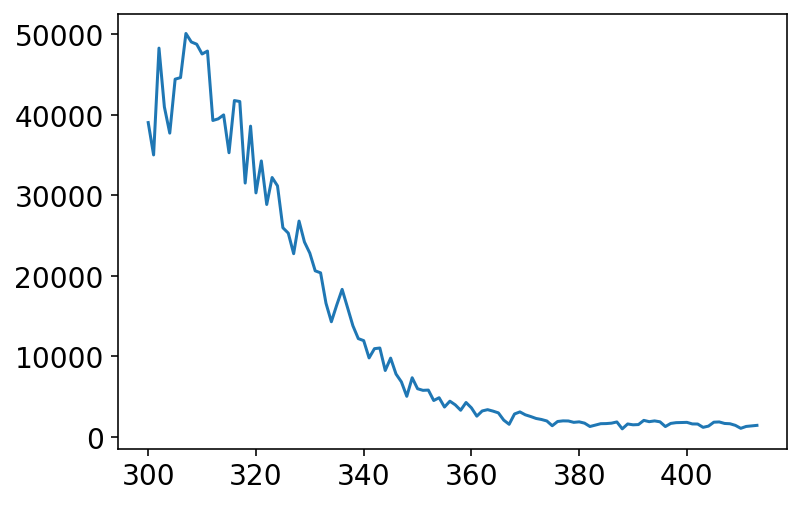

In [10]:
df_actual1=df_actual.iloc[0:414,:].copy(deep=True)
a=np.arange(414)
df_actual1['Day']=a
df_actual1=df_actual1[df_actual1['Day']>299]
log=np.log(df_actual1['Confirmed'])
plt.plot(df_actual1['Day'],df_actual1['Confirmed'])

In [11]:
###### PLOTTER SCRIPT ################
### REL PLot   #####

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

### Reshape DataFrame
def Relplotter(DataFrame, SD_Col_Val, plotExtension,ciBool):
    y_actual=mynewlist[301:len(mynewlist)]
    x_actual=np.arange(301,len(mynewlist))
    df_melt = DataFrame.copy(deep=True)
    listCol = list(DataFrame.columns.values)[731:]
#     df_melt = df_melt.melt(id_vars=listCol, \
#                 var_name="Day", \
#                 value_name="Total")
    df_melt = df_melt.melt(id_vars=listCol, \
                var_name="Day", \
                value_name="Total")

    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    plt.rcParams['axes.labelsize']=18
    
    plt.figure(figsize=(3.5,8))
    plt.rcParams["font.serif"]
    SMALL_SIZE = 18
    MEDIUM_SIZE = 18
    BIGGER_SIZE = 18

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    ### PLotting Parameters
    colorVal = ['#7aa6c2','#4acf94','#b99bce']
    Vacc=["VR-280K","VR-420K","VR-560K"]
    KDPImm = ["IENV-Jul21", "IENV-Sep21","IENV-Nov21" ]
    SDarr=['Good CAB','Partial CAB','No CAB']
    subfig=["(a)","(b)","(c)","(d)","(e)","(f)","(g)","(h)","(i)","(j)","(k)","(l)","(m)","(n)","(o)"]
    ## Filter the Data
    sfg=6
    df_melt=df_melt[df_melt['Day']>300]
    df_melt=df_melt[df_melt['SD']==SD_Col_Val]

    sns.set(style="ticks", rc={"lines.linewidth": 3})
    
    
    
    if(ciBool):
    ### Plotting Script
        relPlot = sns.relplot(data=df_melt, kind="line",
                            x="Day", y="Total",
                            hue="Vaccine Rate",col="KDPwsat2",palette=colorVal,facet_kws=dict(legend_out=False),err_kws={"alpha": .5})
#         relPlot = sns.relplot(data=df_melt, kind="line",
#                             x="Day", y="Antibody",
#                             hue="Vaccine Rate",row="SD",col="KDPwsat2",palette=colorVal,facet_kws=dict(legend_out=False),err_kws={"alpha": .5})
    else:
        relPlot = sns.relplot(data=df_melt, kind="line",ci=None,
                            x="Day", y="Total",
                            hue="Vaccine Rate",col="KDPwsat2",palette=colorVal,facet_kws=dict(legend_out=False),err_kws={"alpha": .5})
#         relPlot = sns.relplot(data=df_melt, kind="line",ci=None,
#                             x="Day", y="Antibody",
#                             hue="Vaccine Rate",col="KDPwsat2",row="SD",palette=colorVal,facet_kws=dict(legend_out=False),err_kws={"alpha": .5})

#     handles = relPlot._legend.
#     labels = relPlot._legend_data.keys()
#     print(labels)
#     print(max(df_melt['Total']))
    h,l = relPlot.axes[0][0].get_legend_handles_labels()
    relPlot.axes[0][0].legend_.remove()


    ## yTicks
    yt = [0,1,2,3,4,5,6,7,8]

    ## Xticks
#     xt = [304,335,365,396,427,457,488,518,549,580,608,639,670,700]   ## 1st days of the months hardcoded 
#     xtl = ['   May\'21','   Jun\'21','   Jul\'21','   Aug\'21','   Sep\'21','   Oct\'21','Nov\'21','Dec\'21', 'Jan\'22','Feb\'22','Mar\'22','Apr\'22','May\'22','Jun\'22']

    xt = [304,365,427,488,549,608,670,731]   ## 1st days of the months hardcoded 
    xtl = ['May\n\'21','Jul\n\'21','Sep\n\'21','Nov\n\'21', 'Jan\n\'22','Mar\n\'22','May\n\'22','Jul\n\'22']

    SDArr = {"SD_RA" : 0,
            "SD_RAR" : 0.1,
            "SD_RARF": 0.2}

    for c in range(1):
        relPlot.axes[c][0].set_ylabel("Active Cases",size = SMALL_SIZE)
        relPlot.axes[c][0].text(-.32,.35,SDarr[2],transform=relPlot.axes[c][0].transAxes,rotation=90,size=SMALL_SIZE)#, fontweight='bold')
        k = relPlot.axes[c][0].get_yticks()
#         if (c==2):
        yt=[0,5e5,1e6,15e5,2e6,25e5,3e6,35e5,4e6]
        ytl=['0','','1M','','2M','','3M','','4M']
        relPlot.axes[c][0].set_yticks(yt)                       ## YTicks 
        relPlot.axes[c][0].set_yticklabels(ytl,size=16)                 ## YTick Labels
        relPlot.axes[c][0].get_yaxis().set_label_coords(-0.18,0.5)
#         else:
#         yt1=[0,1e5,2e5,3e5,4e5,5e5,6e5]
#         ytl1=['0','','200K','','400K','','600K']
#         relPlot.axes[c][0].set_yticks(yt1)                       ## YTicks 
#         relPlot.axes[c][0].set_yticklabels(ytl1,size=16)                 ## YTick Labels
#         relPlot.axes[c][0].get_yaxis().set_label_coords(-0.18,0.5)
            
#         def YTicks(array):
#             array = [item for item in array if item >= 0]
#             Ylabel = []
#             for i in range(len(array)):
#                 if(array[i]/1000000 >=1 ): # Millions
#                     Ylabel.append(str(array[i]/1000000) + "M")

#                 elif(array[i] !=0):                       # Thousands
#                     Ylabel.append(str((int(array[i]/1000))) + "K")
#                 else:
#                     Ylabel.append("0")
#             return array,Ylabel
#         yt,ytl = YTicks(k)

    
        for i in range(3):
            relPlot.axes[c][i].set_xlabel("",size = SMALL_SIZE)                   ## Xlabel
            relPlot.axes[c][i].set_xticks(xt) 
#             xtl=['','','','','','','','']## XTicks 
            relPlot.axes[c][i].set_xticklabels(xtl,size = SMALL_SIZE)                 ## XTick LabelsRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
            relPlot.axes[c][i].tick_params(axis='x', rotation=0);  ## XTicks Rotation
            relPlot.axes[c][i].grid(b=True, which='major', color='grey', linestyle='--',alpha=0.3)
            relPlot.axes[c][i].grid(b=True, which='minor', color='b', linestyle='--',alpha=0.1)
            relPlot.axes[c][i].plot(x_actual,y_actual,color='black')
#             relPlot.axes[c][i].set_yticks(yt)
         
            
            #relPlot.axes[c][i].text(.48,.92,KDPImm[i],horizontalalignment='center',transform=relPlot.axes[c][i].transAxes,size=15)
            relPlot.axes[c][i].set_title("")
            relPlot.axes[c][i].spines['right'].set_visible(True)
            relPlot.axes[c][i].spines['top'].set_visible(True)
            #,fontweight='bold')
            relPlot.axes[c][i].text(.22,.9,subfig[sfg],horizontalalignment='left',transform=relPlot.axes[c][i].transAxes,size=SMALL_SIZE)
#             relPlot.axes[0][i].text(0.50, 1.02,KDPImm[i],horizontalalignment='center',transform=relPlot.axes[0][i].transAxes,size=SMALL_SIZE)
#             relPlot.axes[0][2].text(0.75,1.05,'Actual Data',horizontalalignment='center',transform=relPlot.axes[0][2].transAxes,size=SMALL_SIZE)
            sfg+=1
      
   
    

    
#     plt.rcParams['legend.title_fontsize'] = 18
#     plt.rcParams['legend.title_fontsize'] = SMALL_SIZE
#     l = Vacc
#     l= ["Vaccination Rates: "] + l
#     ph = [plt.plot([],marker="", ls="")[0]] # Canvas
#     h = ph + h
#     relPlot.fig.legend(h, l, loc='upper center',title='',ncol=4,bbox_to_anchor=(0.5,1.05), frameon=False , prop={'size': SMALL_SIZE})
    
    name = "Actual_Final_Relplot_" + plotExtension + ".pdf"
    plt.tight_layout()
    plt.savefig(name,dpi=600,bbox_inches='tight');
    
    
Relplotter(df_nucleation_18minus,"SD_RARF","SD_Worse",False)
# Relplotter(df_Vaccinated,"SD_RAR","SD_RAR",True)
# Relplotter(df_Vaccinated,"SD_RARF","SD_RARF",True)

NameError: name 'df_nucleation_18minus' is not defined

In [13]:
len(mynewlist)

422

AttributeError: 'NoneType' object has no attribute 'remove'

<Figure size 259.2x576 with 0 Axes>

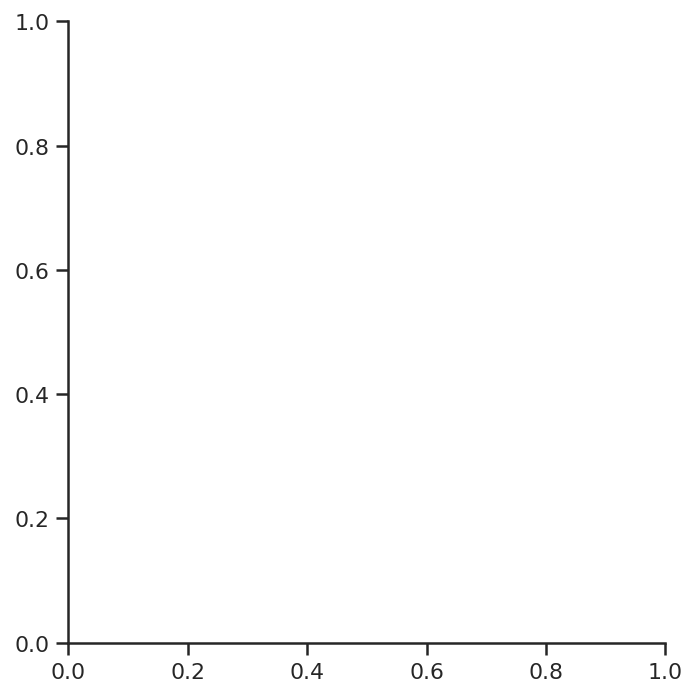

In [14]:
###### PLOTTER SCRIPT ################
### REL PLot   #####

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

### Reshape DataFrame
def Relplotter(DataFrame, IENV_Col_Val, plotExtension,ciBool):
    df_melt = DataFrame.copy(deep=True)
    listCol = list(DataFrame.columns.values)[731:]
#     df_melt = df_melt.melt(id_vars=listCol, \
#                 var_name="Day", \
#                 value_name="Total")
    df_melt = df_melt.melt(id_vars=listCol, \
                var_name="Day", \
                value_name="Total")

    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    plt.rcParams['axes.labelsize']=18
    
    plt.figure(figsize=(3.6,8))
    plt.rcParams["font.serif"]
    SMALL_SIZE = 18
    MEDIUM_SIZE = 18
    BIGGER_SIZE = 18

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    ### PLotting Parameters
    colorVal = ['#7aa6c2','#4acf94','#b99bce']
    Vacc=["VR-280K","VR-420K","VR-560K"]
    KDPImm = ["IENV-Jul21", "IENV-Sep21","IENV-Nov21" ]
    SDarr=['Good CAB','Partial CAB','No CAB']
    subfig=["(a)","(b)","(c)","(d)","(e)","(f)","(g)","(h)","(i)","(j)","(k)","(l)","(m)","(n)","(o)"]
    ## Filter the Data
    sfg=0
    df_melt=df_melt[df_melt['Day']>300]
    df_melt=df_melt[df_melt['KDPwsat2']==IENV_Col_Val]

    sns.set(style="ticks", rc={"lines.linewidth": 3})
    
    
    
    if(ciBool):
    ### Plotting Script
        relPlot = sns.relplot(data=df_melt, kind="line",
                            x="Day", y="Total",
                            hue="Vaccine Rate",col="SD",palette=colorVal,facet_kws=dict(legend_out=False),err_kws={"alpha": .5})
#         relPlot = sns.relplot(data=df_melt, kind="line",
#                             x="Day", y="Antibody",
#                             hue="Vaccine Rate",row="SD",col="KDPwsat2",palette=colorVal,facet_kws=dict(legend_out=False),err_kws={"alpha": .5})
    else:
        relPlot = sns.relplot(data=df_melt, kind="line",ci=None,
                            x="Day", y="Total",
                            hue="Vaccine Rate",col="SD",palette=colorVal,facet_kws=dict(legend_out=False),err_kws={"alpha": .5})
#         relPlot = sns.relplot(data=df_melt, kind="line",ci=None,
#                             x="Day", y="Antibody",
#                             hue="Vaccine Rate",col="KDPwsat2",row="SD",palette=colorVal,facet_kws=dict(legend_out=False),err_kws={"alpha": .5})

#     handles = relPlot._legend.
#     labels = relPlot._legend_data.keys()
#     print(labels)
#     print(max(df_melt['Total']))
    h,l = relPlot.axes[0][0].get_legend_handles_labels()
    relPlot.axes[0][0].legend_.remove()


    ## yTicks
    yt = [0,1,2,3,4,5,6,7,8]

    ## Xticks
#     xt = [304,335,365,396,427,457,488,518,549,580,608,639,670,700]   ## 1st days of the months hardcoded 
#     xtl = ['   May\'21','   Jun\'21','   Jul\'21','   Aug\'21','   Sep\'21','   Oct\'21','Nov\'21','Dec\'21', 'Jan\'22','Feb\'22','Mar\'22','Apr\'22','May\'22','Jun\'22']

    xt = [304,365,427,488,549,608,670,731]   ## 1st days of the months hardcoded 
    xtl = ['May\n\'21','Jul\n\'21','Sep\n\'21','Nov\n\'21', 'Jan\n\'22','Mar\n\'22','May\n\'22','Jul\n\'22']

    SDArr = {"SD_RA" : 0,
            "SD_RAR" : 0.1,
            "SD_RARF": 0.2}

    for c in range(1):
        relPlot.axes[c][0].set_ylabel("Active Cases",size = SMALL_SIZE)
        relPlot.axes[c][0].text(-.32,.35,SDarr[0],transform=relPlot.axes[c][0].transAxes,rotation=90,size=SMALL_SIZE)#, fontweight='bold')
        k = relPlot.axes[c][0].get_yticks()
#         if (c==2):
#         yt=[0,5e5,1e6,15e5,2e6,25e5,3e6,35e5,4e6]
#         ytl=['0','','1M','','2M','','3M','','4M']
#         relPlot.axes[c][0].set_yticks(yt)                       ## YTicks 
#         relPlot.axes[c][0].set_yticklabels(ytl,size=16)                 ## YTick Labels
#         relPlot.axes[c][0].get_yaxis().set_label_coords(-0.18,0.5)
#         else:
        yt1=[0,1e5,2e5,3e5,4e5,5e5,6e5]
        ytl1=['0','','200K','','400K','','600K']
        relPlot.axes[c][0].set_yticks(yt1)                       ## YTicks 
        relPlot.axes[c][0].set_yticklabels(ytl1,size=16)                 ## YTick Labels
        relPlot.axes[c][0].get_yaxis().set_label_coords(-0.18,0.5)
            
#         def YTicks(array):
#             array = [item for item in array if item >= 0]
#             Ylabel = []
#             for i in range(len(array)):
#                 if(array[i]/1000000 >=1 ): # Millions
#                     Ylabel.append(str(array[i]/1000000) + "M")

#                 elif(array[i] !=0):                       # Thousands
#                     Ylabel.append(str((int(array[i]/1000))) + "K")
#                 else:
#                     Ylabel.append("0")
#             return array,Ylabel
#         yt,ytl = YTicks(k)

    
        for i in range(3):
            relPlot.axes[c][i].set_xlabel("",size = SMALL_SIZE)                   ## Xlabel
            relPlot.axes[c][i].set_xticks(xt) 
            xtl=['','','','','','','','']## XTicks 
            relPlot.axes[c][i].set_xticklabels(xtl,size = SMALL_SIZE)                 ## XTick LabelsRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
            relPlot.axes[c][i].tick_params(axis='x', rotation=0);  ## XTicks Rotation
            relPlot.axes[c][i].grid(b=True, which='major', color='grey', linestyle='--',alpha=0.3)
            relPlot.axes[c][i].grid(b=True, which='minor', color='b', linestyle='--',alpha=0.1)
#             relPlot.axes[c][i].set_yticks(yt)
         
            
            #relPlot.axes[c][i].text(.48,.92,KDPImm[i],horizontalalignment='center',transform=relPlot.axes[c][i].transAxes,size=15)
            relPlot.axes[c][i].set_title("")
            relPlot.axes[c][i].spines['right'].set_visible(True)
            relPlot.axes[c][i].spines['top'].set_visible(True)
            #,fontweight='bold')
            relPlot.axes[c][i].text(.22,.9,subfig[sfg],horizontalalignment='left',transform=relPlot.axes[c][i].transAxes,size=SMALL_SIZE)
            relPlot.axes[0][i].text(0.50, 1.02,KDPImm[i],horizontalalignment='center',transform=relPlot.axes[0][i].transAxes,size=SMALL_SIZE)
            sfg+=1
      
   
    

    
    plt.rcParams['legend.title_fontsize'] = 18
    plt.rcParams['legend.title_fontsize'] = SMALL_SIZE
    l = Vacc
    l= ["Vaccination Rates: "] + l
    ph = [plt.plot([],marker="", ls="")[0]] # Canvas
    h = ph + h
    relPlot.fig.legend(h, l, loc='upper center',title='',ncol=4,bbox_to_anchor=(0.5,1.05), frameon=False , prop={'size': SMALL_SIZE})
    
    name = "Final_Relplot_" + plotExtension + ".pdf"
    plt.tight_layout()
    plt.savefig(name,dpi=600,bbox_inches='tight');
    
Relplotter(df_active,"SD_RA","SD_Good",False)
# Relplotter(df_Vaccinated,"SD_RAR","SD_RAR",True)
# Relplotter(df_Vaccinated,"SD_RARF","SD_RARF",True)

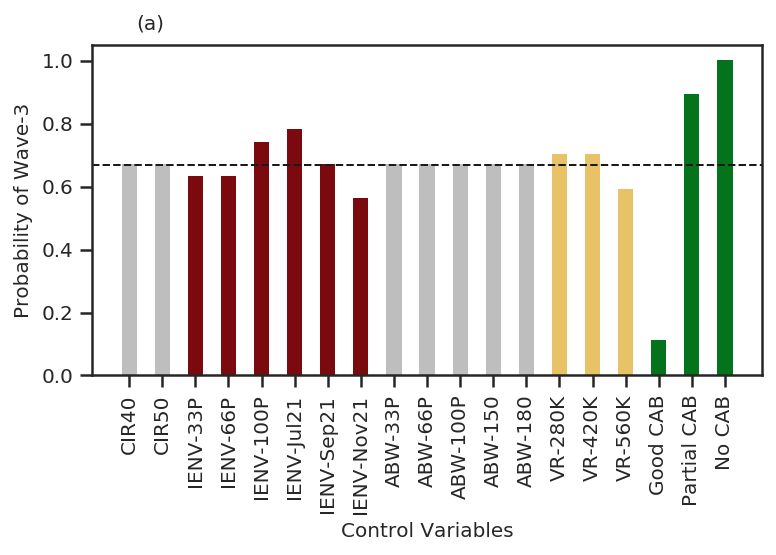

In [15]:
parNames = ['CIR40','CIR50','IENV-33P','IENV-66P','IENV-100P','IENV-Jul21','IENV-Sep21','IENV-Nov21','ABW-33P','ABW-66P','ABW-100P','ABW-150','ABW-180','VR-280K','VR-420K','VR-560K','Good CAB','Partial CAB', 'No CAB']

parValues = [0.67,0.67,0.63,0.63,0.74,0.78,0.67,0.56,0.67,0.67,0.67,0.67,0.67,0.70,0.70,0.59,0.11,0.89,1.0]
baseline=[0.67,0.67,0.63,0.63,0.63,0.56,0.56,0.56,0.67,0.67,0.67,0.67,0.67,0.59,0.59,0.59,0.11,0.11,0.11]
gray='#BEBEBE'
ienv='#7a0a0e'
vr='#e7c267'
cab='#05731b'
colorVal=[gray,gray,ienv,ienv,ienv,ienv,ienv,ienv,gray,gray,gray,gray,gray,vr,vr,vr,cab,cab,cab]
baselineglobal=0.67
parValues1=parValues
# for i in range(len(parValues)):
# #     parValues1[i]=(parValues[i]-baseline[i])*(100/baseline[i])
#     parValues1[i]=(parValues[i]-baselineglobal)*(100/baselineglobal)
# parValues1
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize']=10

plt.rcParams["font.serif"]
SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
fig = plt.figure(figsize = (5.5, 4))
barlist=plt.bar(parNames, parValues,
        width = 0.4)
for i in range(len(colorVal)):
    barlist[i].set_color(colorVal[i])
plt.xticks(rotation=90)
plt.xlabel('Control Variables')
plt.ylabel('Probability of Wave-3')
plt.axhline(y=0.67,linewidth=1,color='k',linestyle='dashed')
plt.text(.22,1.1,'(a)',horizontalalignment='left',size=SMALL_SIZE)
plt.tight_layout()
plt.savefig('barplot_new.png',dpi=500,bbox_inches='tight');
plt.show()

In [22]:
### ---- FUNCTION DEFINITION  ----   ####
### @@ DataGenerator - HistPlot   ###



# DATA GENERATOR - NUMBER OF CASES
####################################_____[[ DATA GENERERATOR ]] FOR NUMBER OF CASES ______________________ #################################

from scipy.stats import norm
import numpy
import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn import preprocessing
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt



def GenerateData(df_active,YColumn,Bandwidth,N_bins,LinePLotVals_Cases,LinePLotX_Cases,NoWaveRatio,boolHist):
    fig, ax = plt.subplots(3,2,figsize=(11,8))
    colorVal = ['#7aa6c2','#4acf94','#b99bce']
    kernel = 'epanechnikov'
    KDPCIR=["CIR= 40", "CIR= 50"]
    KDPImm=["EEscape Period - July","Escape Period - September", "Escape Period  - November"]
    legend = ["Present Rate","1.5x Present Rate","2x Present Rate"]
    SD=["SD_RA","SD_RAR","SD_RARF"]
    
    
    for i in range(3):
        for j in range(2):
            df_kde=df_active.copy(deep=True)
#             df_kde=df_kde[df_kde['CIR']==KDP_nu_name[j]]
            df_kde=df_kde[df_kde['KDPwsat2']==KDP_w_sat_2_name[i]]
            
            #index for storing Lineplot arrays
            plotIndex = 0
            
            for k in range(3):
                df_kdep = df_kde.copy(deep=True)
                df_kdep = df_kdep[df_kdep['SD']==SD[k]].copy(deep=True)
                
                TotalRows = df_kdep.shape[0]   ### NUmber of Rows for this Selected Scenario
                
                ### Remove Rows With DATE_OF_PEAK = 670
                df_kdep = df_kdep[df_kdep['Date Of Peak']!=NOWAVEPEAKDATE].copy(deep=True)
                
                ### Remove the rows with NUmber at Peak < 500 
                df_kdep = df_kdep[df_kdep['Number At Peak']>200].copy(deep=True)
                
                print(df_active.shape[0])
#                 print("Scenario : ",KDPCIR[j],"_",KDPImm[i],"_",legend[k])
#                 print("Total Rows : ", TotalRows)
#                 print("No Wave Peeks : ", df_kdep.shape[0])
#                 print("Max Peak : ", max(df_kdep['Number At Peak']) )
                ## Truncated Rows
                TruncatedRows = df_kdep.shape[0]
                
                
                hist = sns.histplot(ax=ax[i,j],data=df_kdep,x=YColumn,stat='probability',\
                                    kde=True,label=legend[k],kde_kws={"bw_adjust":Bandwidth},
                                    color=colorVal[k],bins=N_bins)
                
 
                ratio = TruncatedRows/TotalRows    #### Compute Ratio of Wave Scenarios
                
                ratioNoWave = 1.0 - ratio;
                print("Total : " ,TotalRows, " TruncatedRows : ",TruncatedRows,   "  RatioNoWave : " , ratioNoWave)
                
                               
                if(len(hist.get_lines()) == plotIndex+1):
                    ll = hist.get_lines()[k].get_data()
                    LinePLotVals_Cases[i][j][k] = np.asarray(ll[1])
                    LinePLotX_Cases[i][j][k] = np.asarray(ll[0])

                    LinePLotVals_Cases[i][j][k] *=  ratio
                    NoWaveRatio[i][j][k]         =  ratioNoWave
                    
                    plotIndex += 1
                
                else:     ##### No Cases Available
                    print("SOMETHING WRONG")
                    NoWaveRatio[i][j][k]        =   ratioNoWave
                    LinePLotVals_Cases[i][j][k] =   np.zeros(len(LinePLotVals_Cases[i][j][k]))
                    LinePLotX_Cases[i][j][k]    =   np.zeros(len(LinePLotX_Cases[i][j][k]))#np.asarray(hist.get_lines()[k].get_data()[0])
                
#                 ###GET MAX Y VALUE for Y lim
 #                maxYVal = max(LinePLotVals_Cases[i][j][k])
                
                if(not boolHist):
                    ax[i,j].containers[0].remove() # remove the bars
                else:
                    ax[i,j].legend(loc='upper right')
                    handles, labels = ax[i,j].get_legend_handles_labels()
                
                
                ax[i,j].set_title(KDPImm[i]+", "+ KDPCIR[j])
                ax[i,j].set_xlabel(YColumn)
    #             ax[i,j].set_xlim([1,5e6])
#                ax[i,j].set_ylim([0,maxYVal+0.05])
        
                
                

#     plt.legend(handles, labels, loc='lower center',title='Vaccination Rate',fancybox=True,ncol=3,bbox_to_anchor=(0.5,0.97))
    plt.tight_layout()

    plt.show()




In [23]:
###-FUNCTION DEFINITION --3x3 Divij--     ####
### @@ CIR PLOTTER - NumCases   ###


from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
###################### ____________________ PLOTTING SCRIPT _______________ ####################################
####  Input parameter -- DataFrame
####  Generates the 2*3 plot for Each CIR Scenario  [Num at Peak for 3 Immune Escape Variants] [Date of Peak for Immune Escape variants]
from matplotlib import axes
from PIL import Image
import io
def CIR_plotter3x3(LinePLotVals_Cases,LinePLotX_Cases,LinePLotVals,LinePLotX,LinePLotVals_Con,LinePLotX_Con, \
               NoWave_NumCases_Ratio,Nowave_DOP_Ratio,NoWave_NumCases_Ratio_Con,PlotNameExtension): 
    print("COMES HERE")
    for cirv in range(2):
        ## 0 - cir40, 1-cir50
        CIRVARIANT = cirv;
        print("CIRV : ", cirv)
        ####### -- PLotter Parameters -- ######
        plt.rcParams["text.usetex"] = False
        plt.rcParams["font.family"] = "serif"
        plt.rcParams["font.serif"] = ["Computer Modern"]
        plt.rcParams['xtick.labelsize'] = 8
        plt.rcParams['ytick.labelsize'] = 8

        SMALL_SIZE = 14
        MEDIUM_SIZE = 14
        BIGGER_SIZE = 14

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

        ## Set plotting parameters   -- Day of Peak
        markersizep = 5
        xtl = []
#         xt = [396,427,457,488,518,549,580,608,639,670+8]   ## 1st days of the months hardcoded 
#         xtl = ['   Aug\'21','   Sep\'21','   Oct\'21','Nov\'21','Dec\'21', 'Jan\'22','Feb\'22','Mar\'22','Apr\'22','No Wave-3']
        xt = [396,427,457,488,518,549,580,608,639]   ## 1st days of the months hardcoded 
        xtl = ['    Aug\'21','','    Oct\'21','','Dec\'21','','Feb\'22','','Apr\'22']
    #     for tickIndex in range(len(xt)):

    #         xtl.append(date_generated[xt[tickIndex]]);
    #         pass;


        ## Set plotting parameters   -- Number at Peak
        markersizep = 5
        nTicks_C = 10
        startDay_C = 0
        endDay_C = 4e6
#         xt_C = [0.3,1,2,3,4,5,6,7,8]
#         xtl_C = ["No Wave-3",r"         $10^{1}$",r"         $10^{2}$",r"    $10^{3}$",r"    $10^{4}$",r"    $10^{5}$",r"    $10^{6}$",r"    $10^{7}$",r"    $10^{8}$" ];
        xt_C = [2,3,4,5,6,7]#,8]
        xtl_C = [r"        $10^{2}$","",r"   $10^{4}$","",r"    $10^{6}$",""]#,r"    $10^{8}$" ];
   
        ## COMMON PLOTTING PARAMETERS
        markeveryVal = 15
        alphaVal = 0.3

        if(CIRVARIANT==0):
            y_limCol1_Val = 0.35
            y_limCol2_Val = 0.3
            y_limCol3_Val = 0.3
        else:
            y_limCol1_Val = 0.35
            y_limCol2_Val = 0.25
            y_limCol3_Val = 0.25

        fig, ax = plt.subplots(3,2,figsize=(11,8),sharex=False,sharey=False)
        fig.tight_layout()
        
        colorVal = ['#7aa6c2','#4acf94','#b99bce']
        marker  = ['o','h','^']
#         legend = ["VR-280K","VR-420K","VR-560K"]
        legend = ["Good CAB","Partial CAB","No CAB"]
        KDPImm = ["IENV-Jul21", "IENV-Sep21","IENV-Nov21" ]
        subfig=["(a)","(b)","(c)","(d)","(e)","(f)","(g)","(h)","(i)","(j)","(k)","(l)","(m)","(n)","(o)"]
        KDPCIR = ["CIR40", "CIR50"]
        sfg=0
        ## MaxValueLegend 
        MaxValueLegend = [];
                 
        j=CIRVARIANT;
        col=0
        for i in range(3):
            for k in range(3):
        #             print( "(i,j) = (", str(i) ,"," ,str(j),") ",   " K val : " , str(k) )
        #            sns.lineplot(ax=ax[i,j],data=LinePLotVals[i][j][k],label=KDP_c_p_name[k])
                ax[i,col].plot(LinePLotX[i][j][k],LinePLotVals[i][j][k],label = legend[k],linewidth=0.75,color=colorVal[k],marker=marker[k],markersize=markersizep,markevery=markeveryVal)

                ax[i,col].fill_between(LinePLotX[i][j][k],LinePLotVals[i][j][k],0, alpha=alphaVal, color=colorVal[k])
                MaxValueLegend.append(max(LinePLotVals[i][j][k]))
                
                BarChartX = LinePLotX[i][j][k].copy()
                
                ##Generate Bar for no Wave Scenario
                # Get the current X array and then append last x as WAVEPEAKDATE  ( x Value )
                # Generate a data with zeros, and append the last value of data as Prob for no peak
                lenX                               =  len(BarChartX)
                PrevXVal                           =  BarChartX[lenX - 1]
                freq                               =  Nowave_DOP_Ratio[i][j][k]
                BarData                            =  np.full(shape=len(BarChartX), fill_value=0.0,dtype=np.float)
                BarChartX[lenX - 1]                =  NOWAVEPEAKDATE + k*8
                BarData[lenX - 1]                  =  freq   
                         
                ## BAr Plot
                #ax[i,col].bar(BarChartX,BarData, color=colorVal[k],width=8)
                
                LinePLotX[i][j][k][lenX - 1]      = PrevXVal
                
                #Append MaxValue to legend Array
                MaxValueLegend.append(freq)
                
                
                
            ax[i,col].legend(title='Vaccination Rate',loc='upper right')
    #         ax[i,col].set_title(KDPImm[i] +", "+ KDPCIR[j], y=10.0, pad=-14)
            ax[i,col].text(.88,.82,subfig[sfg],horizontalalignment='right',transform=ax[i,col].transAxes)
            sfg+=1
            ax[i,col].set_ylabel(KDPImm[i]+"""\nP(D)""")
            
            
            
            ax[i,col].grid(b=True, which='major', color='grey', linestyle='--',alpha=0.3)
            ax[i,col].grid(b=True, which='minor', color='b', linestyle='--',alpha=0.1)
#             ax[i,col].set_xlim()
            ax[i,col].set_ylim((0,y_limCol1_Val))
            ax[i,col].set_xticks(xt);
            ax[i,col].set_xticklabels([]);
            handles, labels = ax[i,col].get_legend_handles_labels()
            ax[i,col].get_legend().remove()
            ax[i,col].get_yaxis().set_label_coords(-0.16,0.5)
            ax[i,col].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        ax[2,col].set_xlabel("""Date of peak (D)""")
        ax[2,col].set_xticks(xt);
        ax[2,col].set_xticklabels(xtl);
        ax[2,col].tick_params(axis='x', rotation=30);


        ### --- NUMBER OF CASES ----- ######

        col=1
                 
        MaxValueLegend = []

        for i in range(3):
            for k in range(3):
                ax[i,col].plot(LinePLotX_Cases[i][j][k],LinePLotVals_Cases[i][j][k],label = legend[k],linewidth=0.75,color=colorVal[k],marker=marker[k],markersize=markersizep,markevery=markeveryVal)
                ax[i,col].fill_between(LinePLotX_Cases[i][j][k],LinePLotVals_Cases[i][j][k],0, alpha=alphaVal, color=colorVal[k])
                
                MaxValueLegend.append(max(LinePLotVals[i][j][k]))
                
                BarChartX                          =  LinePLotX[i][j][k].copy()
                
                ##Generate Bar for no Wave Scenario
                # Get the current X array and then append last x as WAVEPEAKDATE  ( x Value )
                # Generate a data with zeros, and append the last value of data as Prob for no peak
                lenX                               =  len(BarChartX)
                PrevXVal                           =  BarChartX[0]
                freq                               =  NoWave_NumCases_Ratio[i][j][k]
                BarData                            =  np.full(shape=len(BarChartX), fill_value=0.0,dtype=np.float)
                BarChartX[0]                       =  0 + k*0.2 + 0.1
                BarData[0]                         =  freq   
                
                
                
                
                ## BAr Plot
                ax[i,col].bar(BarChartX,BarData, color=colorVal[k],width=0.2)
                
                LinePLotX[i][j][k][0] = PrevXVal
                
                #Append MaxValue to legend Array
                MaxValueLegend.append(freq)
                
            
            ax[i,col].legend(title='Vaccination Rate',loc='upper right')
    #         ax[i,col].set_title(, position=(0.5, 4.6))
            ax[i,col].text(.88,.85,subfig[sfg],horizontalalignment='right',transform=ax[i,col].transAxes)
            sfg+=1
    #         ax[i,col].set_ylabel("""1""")
            ax[i,col].grid(b=True, which='major', color='grey', linestyle='--',alpha=0.3)
            ax[i,col].grid(b=True, which='minor', color='b', linestyle='--',alpha=0.1)
            
            ax[i,col].set_xticks(xt_C);
            ax[i,col].set_xlim([3,7]);
            ax[i,col].set_xticklabels([]);
            ax[i,col].set_ylim((0,y_limCol2_Val))
            ax[i,col].set_ylabel("""P(A)""")
            handles, labels = ax[i,col].get_legend_handles_labels()
            ax[i,col].get_legend().remove()
            ax[i,col].get_yaxis().set_label_coords(-0.16,0.5)
            ax[i,col].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            

        
        if(PlotNameExtension == "TotalActive"):
            ax[2,col].set_xlabel("""Total active cases at peak (A)""")
        else:
            ax[2,col].set_xlabel("""Daily active cases at peak (A)\n\n\n\nDaily confirmed cases at peak (C)""")
    #     ax[2,col].yaxis.set_label_coords(-0.075,.5)
        xt_C1 = [3,4,5,6,7]#,8]
        xtl_C1 = [r"$10^{3}$","",r"$10^{5}$","",r"$10^{7}$"]#,r"    $10^{8}$" ];
        ax[2,col].set_xticks(xt_C1);
        ax[2,col].set_xticklabels(xtl_C1);
        ax[2,col].tick_params(axis='x', rotation=0);
        
        
        ax3=ax[2,col].twiny()
        ax3.spines["top"].set_position(("axes", -0.6))
        #ax3.axis["bottom"].toggle(all=True)
#             ax3.spines.bottom.set_position(("axes", 1.2))
#            ax3.set_xticks(xt_C);
        ax3.set_xlim([2,6]);
        ax3.set_xticklabels([])
        
            
        
        
        #ax3.set_xlabel("""Daily confirmed cases at peak (C)""")
    #     ax[2,col].yaxis.set_label_coords(-0.075,.5)
        xt_C2 = [2,3,4,5,6]#,8]
        xtl_C2 = [r"$10^{2}$","",r"$10^{4}$","",r"$10^{6}$"]#,r"    $10^{8}$" ];
        ax3.set_xticks(xt_C2);
        ax3.set_xticklabels(xtl_C2);
        ax3.tick_params(axis='x', rotation=0);
        
        
        
        #ax3.xaxis.tick_bottom()
        
        #make_patch_spines_invisible(ax3)
# Second, show the right spine.
        #ax3.spines["bottom"].set_visible(True)
        #####Daily confirmed Cases#########
        
#         col=2
                 
#         MaxValueLegend = []

#         for i in range(3):
#             for k in range(3):
#                 ax[i,col].plot(LinePLotX_Con[i][j][k],LinePLotVals_Con[i][j][k],label = legend[k],linewidth=0.75,color=colorVal[k],marker=marker[k],markersize=markersizep,markevery=markeveryVal)
#                 ax[i,col].fill_between(LinePLotX_Con[i][j][k],LinePLotVals_Con[i][j][k],0, alpha=alphaVal, color=colorVal[k])
                
#                 MaxValueLegend.append(max(LinePLotVals_Con[i][j][k]))
                
#                 BarChartX                          =  LinePLotX[i][j][k].copy()
                
#                 ##Generate Bar for no Wave Scenario
#                 # Get the current X array and then append last x as WAVEPEAKDATE  ( x Value )
#                 # Generate a data with zeros, and append the last value of data as Prob for no peak
#                 lenX                               =  len(BarChartX)
#                 PrevXVal                           =  BarChartX[0]
#                 freq                               =  NoWave_NumCases_Ratio_Con[i][j][k]
#                 BarData                            =  np.full(shape=len(BarChartX), fill_value=0.0,dtype=np.float)
#                 BarChartX[0]                       =  0 + k*0.2 + 0.1
#                 BarData[0]                         =  freq   
                
                
                
                
#                 ## BAr Plot
#                 #ax[i,col].bar(BarChartX,BarData, color=colorVal[k],width=0.2)
                
#                 LinePLotX[i][j][k][0] = PrevXVal
                
#                 #Append MaxValue to legend Array
#                 MaxValueLegend.append(freq)
                

#             ax[i,col].legend(title='Vaccination Rate',loc='upper right')
#     #         ax[i,col].set_title(, position=(0.5, 4.6))
#             ax[i,col].text(.88,.85,subfig[sfg],horizontalalignment='right',transform=ax[i,col].transAxes)
#             sfg+=1
#     #         ax[i,col].set_ylabel("""1""")
#             ax[i,col].grid(b=True, which='major', color='grey', linestyle='--',alpha=0.3)
#             ax[i,col].grid(b=True, which='minor', color='b', linestyle='--',alpha=0.1)
            
#             ax[i,col].set_xticks(xt_C);
#             ax[i,col].set_xlim([2,6]);
#             ax[i,col].set_xticklabels([])
            
#             ax[i,col].set_ylim((0,y_limCol3_Val))
#             ax[i,col].set_ylabel("""P(C)""")
            
#             ax2=ax[i,col].twinx()
#             ax2.set_ylabel(KDPImm[i])
#             ax2.tick_params(axis='y',which='both',right=False,labelright=False)
            
            
            
#             handles, labels = ax[i,col].get_legend_handles_labels()
#             ax[i,col].get_legend().remove()
#             ax[i,col].get_yaxis().set_label_coords(-0.18,0.5)
#             ax[i,col].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
#         if(PlotNameExtension == "TotalActive"):
#             ax[2,col].set_xlabel("""Total active cases at peak (A)""")
#         else:
#             ax[2,col].set_xlabel("""Daily confirmed cases at peak (C)""")
#     #     ax[2,col].yaxis.set_label_coords(-0.075,.5)
#         xt_C2 = [2,3,4,5,6]#,8]
#         xtl_C2 = [r"          $10^{2}$","",r"     $10^{4}$","",r"     $10^{6}$"]#,r"    $10^{8}$" ];
#         ax[2,col].set_xticks(xt_C2);
#         ax[2,col].set_xticklabels(xtl_C2);
#         ax[2,col].tick_params(axis='x', rotation=30);
        
################################################################################################################
        ax4=ax[0,1].twinx()
        ax4.set_ylabel("\nP(C)")
        
        ax4.set_ylim((0,y_limCol2_Val))
        ax4.set_yticklabels(["","",""]);
        ax4.tick_params(labelright=False)
        ax4.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax4.get_yaxis().set_label_coords(1,0.5)
        ax5=ax[1,1].twinx()
        ax5.set_ylabel("\nP(C)")
       
        ax5.set_ylim((0,y_limCol2_Val))
        ax5.set_yticklabels(["","",""]);
        ax5.tick_params(labelright=False)
        ax5.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax5.get_yaxis().set_label_coords(1,0.5)
        ax6=ax[2,1].twinx()
        ax6.set_ylabel("\nP(C)")
        
        ax6.set_ylim((0,y_limCol2_Val))
        ax6.set_yticklabels(["","",""]);
        ax6.tick_params(labelright=False)
        ax6.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax6.get_yaxis().set_label_coords(1,0.5)
        ph = [plt.plot([],marker="", ls="")[0]] # Canvas
        handles = ph + handles
        labels= ["COVID Appropriate Behaviour:"]+labels
        fig.legend(handles, labels, loc=10,title='',ncol=4,bbox_to_anchor=(0.475,0.98),frameon=False,title_fontsize=15,fontsize=15)
        
        fig.tight_layout()
        fig.subplots_adjust(wspace=0.3,hspace=0.3,bottom=0.2)
        
        
        print("SavePlot Start");
        if(CIRVARIANT==0): 
            name = "SD"
            name = name + "_" + PlotNameExtension+"divijnew" 
            
            plt.savefig(name + ".pdf",dpi=500,bbox_inches='tight')
            png1=io.BytesIO()
            plt.savefig(png1,format="png",dpi=500,bbox_inches='tight')
            png2=Image.open(png1)
            png2.save(name+".tiff",compression='tiff_lzw')
            png1.close()
#             fig.savefig(name+".tiff",dpi=500,bbox_inches='tight')
        else:
            print(" SHOULD COME HERE")
            name = "CIR50"
            name = name + "_" + PlotNameExtension+"divij"
            plt.savefig(name + ".png",dpi=300,bbox_inches='tight')
        
        print("SavePlot End");
        
        
        plt.show()
        plt.draw()



Size before GenData 1:  972
972
Total :  108  TruncatedRows :  36   RatioNoWave :  0.6666666666666667
972
Total :  108  TruncatedRows :  108   RatioNoWave :  0.0
972


No handles with labels found to put in legend.


Total :  108  TruncatedRows :  108   RatioNoWave :  0.0
972
Total :  108  TruncatedRows :  36   RatioNoWave :  0.6666666666666667
972
Total :  108  TruncatedRows :  108   RatioNoWave :  0.0
972
Total :  108  TruncatedRows :  108   RatioNoWave :  0.0
972
Total :  108  TruncatedRows :  0   RatioNoWave :  1.0
SOMETHING WRONG
972
Total :  108  TruncatedRows :  108   RatioNoWave :  0.0


IndexError: list index out of range

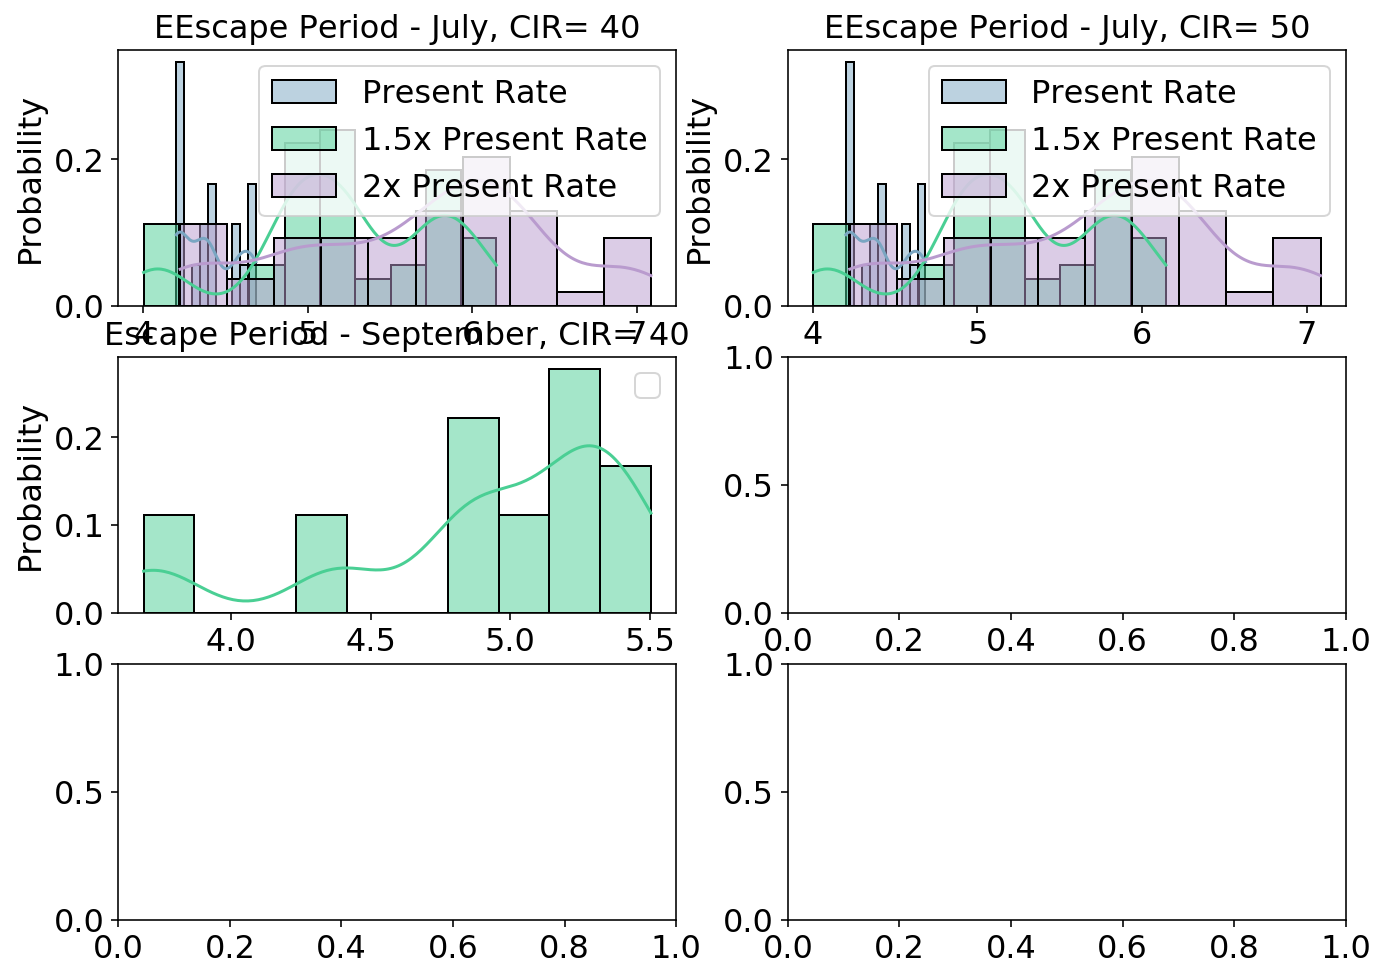

In [24]:
###--- PLOTTING CELL   3x3 Divij   ####
### @@ CIR PLOT    ###

############### Function for Plotting #####################################

def plotDataFrame3x3(DataFrameName,DataFrameName2,plotName):
#     DataFrameName = AddPeakInfo(DataFrameName,700,False)

    ## For Number of Cases    
    LinePLotVals_Cases = np.empty(shape=(3,2,3,200))
    LinePLotX_Cases = np.empty(shape=(3,2,3,200))

    ## For Date of Peak
    LinePLotVals = np.empty(shape=(3,2,3,200))
    LinePLotX = np.empty(shape=(3,2,3,200))
    
    ##For daily confirmed cases
    LinePLotVals_Con = np.empty(shape=(3,2,3,200))
    LinePLotX_Con = np.empty(shape=(3,2,3,200))
    
    
    ### For Storing Ratio of No Peak in Each cases
    NoWave_NumCases_Ratio = np.empty(shape = (3,2,3,1))
    Nowave_DOP_Ratio = np.empty(shape = (3,2,3,1))
    NoWave_NumCases_Ratio_Con = np.empty(shape = (3,2,3,1))
    
    
    ### Data for Number at Peak
    print("Size before GenData 1: ", DataFrameName.shape[0])
    GenerateData(DataFrameName,'LogNumAtPeak',0.8,10,LinePLotVals_Cases,LinePLotX_Cases,NoWave_NumCases_Ratio,True)
    print("Size Aftr GenData 1: ", df_nucleation_total.shape[0])
    
    ### Data for Day of Peak
    print("Size before GenData1: ", DataFrameName.shape[0])
    GenerateData(DataFrameName,'Date Of Peak',0.8,10,LinePLotVals,LinePLotX,Nowave_DOP_Ratio,True)
    print("Size After GenData1: ", DataFrameName.shape[0])
    
    #####Data for daily confirmed
    print("Size before GenData1: ", DataFrameName2.shape[0])
    GenerateData(DataFrameName2,'LogNumAtPeak',0.8,10,LinePLotVals_Con,LinePLotX_Con,NoWave_NumCases_Ratio_Con,True)
    print("Size After GenData1: ", DataFrameName2.shape[0])
    ### PLot the values in seperate plots
    CIR_plotter3x3(LinePLotVals_Cases,LinePLotX_Cases,LinePLotVals,LinePLotX,LinePLotVals_Con,LinePLotX_Con,\
                NoWave_NumCases_Ratio,Nowave_DOP_Ratio,NoWave_NumCases_Ratio_Con,plotName)
    
#     SCATTER_plotter(df_active,plotName)

# plotDataFrame(df_nucleation_11,"nucleation_11")
# plotDataFrame(df_nucleation_18,"nucleation_18")
# plotDataFrame(df_nucleation_45,"nucleation_45")
# plotDataFrame(df_nucleation_60,"nucleation_60")
# plotDataFrame(df_nucleation_60plus,"nucleation_60plus")
#plotDataFrame(df_active,"TotalActive")
plotDataFrame3x3(df_active,df_nucleation_total,"Divij_New")
#plotDataFrame(df_nucleation_total,"DailyConfirmed")



# #EXTRA -- REMOVE THEM
# LinePLotVals_Cases = np.empty(shape=(3,2,3,200))
# LinePLotX_Cases = np.empty(shape=(3,2,3,200))

# ## For Date of Peak
# LinePLotVals = np.empty(shape=(3,2,3,200))
# LinePLotX = np.empty(shape=(3,2,3,200))


# ### For Storing Ratio of No Peak in Each cases
# NoWave_NumCases_Ratio = np.empty(shape = (3,2,3,1))
# Nowave_DOP_Ratio = np.empty(shape = (3,2,3,1))

# HANDLES,LABELS = CIR_plotter(LinePLotVals_Cases,LinePLotX_Cases,LinePLotVals,LinePLotX, \
#                 NoWave_NumCases_Ratio,Nowave_DOP_Ratio,"test")

In [45]:
##### TABLE GENERATOR ######
## @@ AGEWISE Cases Probability Table ##

import statistics
import scipy.stats as st


def TableGenerator_Age(df_active,Col_Param1,Col_Param2,ColHead,RowHead,Row_Param):
    ## list of Parameter

    ## Arrays to Store probabilitites
    waveProbArray             = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    
    MeanRatioPeak          = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    WeightedMean          = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    CIMeanRatioPeak   = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    stddevMeanRatioPeak=np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    iqrMeanRatioPeak   = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    minRatioPeak   = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    maxRatioPeak   = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    RatioPeaklowerp=np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    RatioPeakupperp=np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    lowerp=25
    upperp=75
    
    MedianRatioPeak          = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    CIMeanRatioPeakLower  = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    CIMeanRatioPeakUpper  = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    iqrMedianRatioPeak   = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    
    KDP_lambda_name=["SD_RA","SD_RAR","SD_RARF"]
    globalmean=0

    
    for i in range(len(Row_Param)):
        datepeak2wave=[]
        ## Filter for Both Rows and SubRows
        df_heat_Row_m =  Row_Param[i].copy(deep=True)
        for ia in range(len(df_active)):
                    dop1,dict1 = scipy.signal.find_peaks(df_active.iloc[[ia]].transpose().loc[300:400,'Total'],distance = 60,height=2000)
                    datepeak2wave.append(dop1[0]+300)
        df_heat_Row_m['Peak2Date']=datepeak2wave
        df_heat_Row = df_heat_Row_m[df_heat_Row_m["SD"] == KDP_lambda_name[i%3]]
#         df_heat_Row=  Row_Param[i].copy(deep=True)
        
        for j in range(len(Col_Param1)):
            
            ## Filter for j - First Parameeter - Vaccine Rate
            df_heat_col1 = df_heat_Row[df_heat_Row["Vaccine Rate"] == Col_Param1[j]]
            df_heat1     = df_heat_col1[df_heat_col1["KDPwsat2"] == Col_Param2[j]]
            
            totalCases = df_heat1.shape[0]
            
            ## remove no wave scenarios
            df_heat2 = df_heat1[df_heat1["Date Of Peak"] != NOWAVEPEAKDATE].copy(deep=True)
            wave3Cases    = df_heat2.shape[0]
            if(wave3Cases):

                ratioWave3    = wave3Cases/totalCases
                waveProbArray[i][j] = ratioWave3
                
            
                
                wave2List = df_heat2['Peak2Date']
                Wave3List = df_heat2['Number At Peak'].copy(deep = True)
                RatioList = Wave3List.div(wave2List)
                
                
                #### MEDIAN NUMBER AT PEAK  
                MedianRatioPeak[i][j] = np.median(RatioList)
                RatioPeaklowerp[i][j]=np.percentile(RatioList,lowerp)
                RatioPeakupperp[i][j]=np.percentile(RatioList,upperp)
#                 ci_MedianRatioAtPeak=st.t.interval(0.95,wave3Cases-1,loc=np.median(RatioList),scale=scipy.stats.sem(RatioList))
                iqr_MedianRatioAtPeak=st.iqr(RatioList)
                #print(ci_MedianRatioAtPeak)
                #CIMedianRatioPeak[i][j] = abs(  max(ci_MedianRatioAtPeak)  - MedianRatioPeak[i][j] )
                iqrMedianRatioPeak[i][j]=iqr_MedianRatioAtPeak
                min_MedianRatioAtPeak=np.min(RatioList)
                minRatioPeak[i][j]=np.min(RatioList)
                maxRatioPeak[i][j]=np.max(RatioList)
               
                
                
                ### MEan Ratio at peak
                MeanRatioPeak[i][j] = statistics.mean(RatioList)
                WeightedMean[i][j] = (MeanRatioPeak[i][j])*(wave3Cases/648)
                globalmean+=WeightedMean[i][j]
                
                ci_MeanRatioAtPeak=st.t.interval(0.95,wave3Cases-1,loc=np.mean(RatioList),scale=scipy.stats.sem(RatioList))
                iqr_MeanRatioAtPeak=st.iqr(RatioList)
                #print(ci_MedianRatioAtPeak)
                CIMeanRatioPeak[i][j] = abs(  max(ci_MeanRatioAtPeak)  - MeanRatioPeak[i][j] )
                CIMeanRatioPeakLower[i][j]=ci_MeanRatioAtPeak[0]
                CIMeanRatioPeakUpper[i][j]=ci_MeanRatioAtPeak[1]
                iqrMeanRatioPeak[i][j] = iqr_MeanRatioAtPeak
                stddevMeanRatioPeak[i][j]=np.std(RatioList)
                
                            
#             else:
#                 MedianDateAtpeak[i][j] = "No Wave 3"
                

#                 plt.hist(RatioList)
#                 plt.title(str(KDP_lambda_name[i%3])+" "+str(Col_Param1[j])+" "+str(Col_Param2[j]))
#                 plt.show()
    
    return MedianRatioPeak,RatioPeaklowerp,RatioPeakupperp , RatioList,CIMeanRatioPeak,stddevMeanRatioPeak,CIMeanRatioPeakLower,CIMeanRatioPeakUpper,MeanRatioPeak, wave2List, datepeak2wave, WeightedMean,globalmean

list_param1=["ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov","Vaccine_PresentRate", "Vaccine_BestWeekAvg", "Vaccine_TwicePresent","SD_RA","SD_RAR","SD_RARF"]
list_head1=["KDPwsat2","KDPwsat2","KDPwsat2","Vaccine Rate","Vaccine Rate","Vaccine Rate","SD","SD","SD"]
list_label=["IENV-Jul21" ,"IENV-Sep21", "IENV-Nov21","VR-100P", "VR-150P", "VR-200P","SD-Good","SD-Bad","SD-Worse"]

Col_Param2  = ["ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov","ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov","ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov"]
Col_Param1  = ["Vaccine_PresentRate", "Vaccine_PresentRate", "Vaccine_PresentRate", "Vaccine_BestWeekAvg", "Vaccine_BestWeekAvg", "Vaccine_BestWeekAvg","Vaccine_TwicePresent","Vaccine_TwicePresent","Vaccine_TwicePresent", ]
ColHead     = ["KDPwsat2","Vaccine Rate"]

RowHead     = ["SD"]
# Row_Param   = [df_nucleation_11,df_nucleation_11,df_nucleation_11,
#                df_nucleation_18,df_nucleation_18,df_nucleation_18,
#                df_nucleation_45,df_nucleation_45,df_nucleation_45,
#                df_nucleation_60,df_nucleation_60,df_nucleation_60,
#               df_nucleation_60plus,df_nucleation_60plus,df_nucleation_60plus]
Row_Param   = [df_nucleation_11,
               df_nucleation_18,
               df_nucleation_45,
               df_nucleation_60,
              df_nucleation_60plus]
# Row_Param   = [df_nucleation_11,
#                df_nucleation_18]
# minRatioPeak,maxRatioPeak,waveProbArray, MedianRatioPeak, CIMedianRatioPeak , MeanRatioPeak , CIMeanRatioPeak,iqrMeanRatioPeak,iqrMedianRatioPeak, RatioList= \
# TableGenerator_Age(df_active,Col_Param1,Col_Param2,ColHead,RowHead,Row_Param)
MedianRatioPeak,RatioPeaklowerp,RatioPeakupperp, RatioList,CIMeanRatioPeak,stddevMeanRatioPeak,CIMeanRatioPeakLower,CIMeanRatioPeakUpper,MeanRatioPeak,wave2List, datepeak2wave, WeightedMean, globalmean=TableGenerator_Age(df_active,Col_Param1,Col_Param2,ColHead,RowHead,Row_Param)

In [46]:
# np.set_printoptions(linewidth=200)

def formatter(array):
    ans =  np.zeros(shape=(array.shape[0],array.shape[1]), dtype = object)
    row = array.shape[0]
    col = array.shape[1]
    
    for i in range(row):
        for j in range(col):
            val = array[i][j]
            if(val == 0):
                ans[i][j] = "0"
            elif( int(val / 1000000) >= 1):
                ans[i][j] =  str(int(val/1000000)) + "M"
#                 print (str(int(val/1000000)) + "M")
            elif( int(val / 1000) >= 1):
                ans[i][j] =  str(int(val/1000)) + "K"
#                 print (str(int(val/1000)) + "K")
            else:
                ans[i][j] =  str(int(val))
            
            
        pass;
    return ans;
    pass;

# ans  = formatter(MaxNumAtPeak)
# ans = MedianRatioPeak
ans = WeightedMean

for i in range(ans.shape[0]):
    for j in range(ans.shape[1]):
        print("{:.2f}".format(ans[i][j]) ,",",end = '')
    print("\n",end = '')


0.02 ,0.00 ,0.00 ,0.01 ,0.00 ,0.00 ,0.01 ,0.00 ,0.00 ,
1.09 ,0.70 ,0.63 ,0.88 ,0.46 ,0.20 ,0.66 ,0.16 ,0.00 ,
7.53 ,3.39 ,14.72 ,6.47 ,2.73 ,7.17 ,5.56 ,2.29 ,2.76 ,
0.12 ,0.00 ,0.00 ,0.07 ,0.00 ,0.00 ,0.05 ,0.00 ,0.00 ,
0.48 ,0.07 ,0.01 ,0.27 ,0.00 ,0.00 ,0.14 ,0.00 ,0.00 ,


In [16]:
df_nucleation_11

,0,1,2,3,4,5,6,7,8,9,...,SD,KDPwsat2,KDPLambda,KDPwsat1,KDPg1,KDPg2,Scenario,Date Of Peak,Number At Peak,LogNumAtPeak
Total,83.0,77.0,69.0,68.0,71.0,75.0,80.0,86.0,92.0,99.0,...,SD_RA,ImmunEscp_Jul,SD_RA,0_33,0_33,ABW150Days,1,670,2,0
Total,83.0,77.0,69.0,68.0,71.0,75.0,80.0,86.0,92.0,99.0,...,SD_RAR,ImmunEscp_Jul,SD_RAR,0_33,0_33,ABW150Days,2,548,2968,3
Total,83.0,77.0,69.0,68.0,71.0,75.0,80.0,86.0,92.0,99.0,...,SD_RARF,ImmunEscp_Jul,SD_RARF,0_33,0_33,ABW150Days,3,426,2203,3
Total,83.0,77.0,69.0,68.0,71.0,75.0,80.0,86.0,92.0,99.0,...,SD_RA,ImmunEscp_Jul,SD_RA,0_33,0_33,ABW150Days,4,670,2,0
Total,83.0,77.0,69.0,68.0,71.0,75.0,80.0,86.0,92.0,99.0,...,SD_RAR,ImmunEscp_Jul,SD_RAR,0_33,0_33,ABW150Days,5,564,1910,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Total,83.0,77.0,69.0,68.0,71.0,75.0,80.0,86.0,92.0,98.0,...,SD_RAR,ImmunEscp_Nov,SD_RAR,1_00,1_00,ABW180Days,968,618,1295,3
Total,83.0,77.0,69.0,68.0,71.0,75.0,80.0,86.0,92.0,98.0,...,SD_RARF,ImmunEscp_Nov,SD_RARF,1_00,1_00,ABW180Days,969,542,77519,4
Total,83.0,77.0,69.0,68.0,71.0,75.0,80.0,86.0,92.0,98.0,...,SD_RA,ImmunEscp_Nov,SD_RA,1_00,1_00,ABW180Days,970,670,2,0
Total,83.0,77.0,69.0,68.0,71.0,75.0,80.0,86.0,92.0,98.0,...,SD_RAR,ImmunEscp_Nov,SD_RAR,1_00,1_00,ABW180Days,971,670,2,0


In [22]:
df11=df_nucleation_11.copy(deep=True)
df11=df11[df11["Date Of Peak"] != NOWAVEPEAKDATE]
df18=df_nucleation_18.copy(deep=True)
df18=df18[df18["Date Of Peak"] != NOWAVEPEAKDATE]
CIR=[40,50]
CIRName=["CIR40","CIR50"]
IENV=["ImmunEscp_Jul","ImmunEscp_Sep","ImmunEscp_Nov"]

MISC=np.zeros((2,3))
MEAN=np.zeros((2,3))
for i in range(2):
    for j in range(3):
        dftemp11 = df11.copy(deep=True)
        dftemp11=dftemp11[dftemp11['CIR']==CIRName[i]]
        dftemp11=dftemp11[dftemp11['KDPwsat2']==IENV[j]]
        mean11 = np.mean(dftemp11['Number At Peak'])
        
        dftemp18 = df18.copy(deep=True)
        dftemp18=dftemp18[dftemp18['CIR']==CIRName[i]]
        dftemp18=dftemp18[dftemp18['KDPwsat2']==IENV[j]]
        mean18 = np.mean(dftemp18['Number At Peak'])
        mean = mean11 + mean18
        MEAN[i][j] = int(mean)
        MISC[i][j] = int(316*1e-6*CIR[i]*mean)
        
MEAN

array([[40622., 22486., 75968.],
       [32876., 17434., 45183.]])

In [22]:
df1=df_active.copy(deep=True)
df1=df1[df1['SD']=='SD_RARF']
df1=df1[df1['KDPwsat2']=='ImmunEscp_Jul']
df1

,0,1,2,3,4,5,6,7,8,9,...,SD,KDPwsat2,KDPLambda,KDPwsat1,KDPg1,KDPg2,Scenario,Date Of Peak,Number At Peak,LogNumAtPeak
Total,8195.0,9273.0,10113.0,10870.0,11626.0,12419.0,13268.0,14180.0,15160.0,16210.0,...,SD_RARF,ImmunEscp_Jul,SD_RARF,0_33,0_33,ABW150Days,3,437,98844.0,4.994950
Total,8195.0,9273.0,10113.0,10870.0,11626.0,12419.0,13268.0,14180.0,15160.0,16210.0,...,SD_RARF,ImmunEscp_Jul,SD_RARF,0_33,0_33,ABW150Days,6,437,70227.0,4.846504
Total,8195.0,9273.0,10113.0,10870.0,11626.0,12419.0,13268.0,14180.0,15160.0,16210.0,...,SD_RARF,ImmunEscp_Jul,SD_RARF,0_33,0_33,ABW150Days,9,434,51320.0,4.710287
Total,8195.0,9273.0,10113.0,10870.0,11626.0,12419.0,13268.0,14180.0,15160.0,16210.0,...,SD_RARF,ImmunEscp_Jul,SD_RARF,0_33,0_33,ABW180Days,12,437,98844.0,4.994950
Total,8195.0,9273.0,10113.0,10870.0,11626.0,12419.0,13268.0,14180.0,15160.0,16210.0,...,SD_RARF,ImmunEscp_Jul,SD_RARF,0_33,0_33,ABW180Days,15,437,70227.0,4.846504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Total,8195.0,9272.0,10110.0,10865.0,11618.0,12407.0,13250.0,14155.0,15126.0,16164.0,...,SD_RARF,ImmunEscp_Jul,SD_RARF,1_00,1_00,ABW150Days,852,418,7370039.0,6.867470
Total,8195.0,9272.0,10110.0,10865.0,11618.0,12407.0,13250.0,14155.0,15126.0,16164.0,...,SD_RARF,ImmunEscp_Jul,SD_RARF,1_00,1_00,ABW150Days,855,419,5915887.0,6.772020
Total,8195.0,9272.0,10110.0,10865.0,11618.0,12407.0,13250.0,14155.0,15126.0,16164.0,...,SD_RARF,ImmunEscp_Jul,SD_RARF,1_00,1_00,ABW180Days,858,418,9221597.0,6.964806
Total,8195.0,9272.0,10110.0,10865.0,11618.0,12407.0,13250.0,14155.0,15126.0,16164.0,...,SD_RARF,ImmunEscp_Jul,SD_RARF,1_00,1_00,ABW180Days,861,418,7370039.0,6.867470


In [ ]:
4400*7*316

In [23]:
df_new=df_active.copy(deep=True)
# df_new=df_new[df_new['Scenario']==269]
# df_new['Vaccine Rate']
# plt.plot(df_new.iloc[0,0:730])
datepeak2wave=[]
numatpeak2wave=[]
for ia in range(len(df_new)):
    dop1,dict1 = scipy.signal.find_peaks(df_new.iloc[[ia]].transpose().loc[300:400,'Total'],distance = 60,height=2000)
    datepeak2wave.append(dop1[0]+310:22
￼
Median :
 	VR-100P	VR-150P	VR-200P
Emergence of
IENV	Jul'21	Sep'21	Nov'21	Jul'21	Sep'21	Nov'21	Jul'21	Sep'21	Nov'21
Probability of Wave-3	0.78	0.67	0.67	0.78	0.67	0.67	0.78	0.65	0.33
0-11 Years	1.71	2.44	1.95	0.99	1.84	0.61	0.68	0.93	7.05
12-18 Years	1.21	2.02	1.56	0.79	1.49	0.53	0.55	0.78	5
18+ Years	0.23	0.4	0.21	0.11	0.17	0.02	0.06	0.05	0.3
10:22
￼
Median :
 	VR-100P	VR-150P	VR-200P
Emergence of
IENV	Jul'21	Sep'21	Nov'21	Jul'21	Sep'21	Nov'21	Jul'21	Sep'21	Nov'21
Probability of Wave-3	0.78	0.67	0.67	0.78	0.67	0.67	0.78	0.65	0.33
0-11 Years	1.71	2.44	1.95	0.99	1.84	0.61	0.68	0.93	7.05
12-18 Years	1.21	2.02	1.56	0.79	1.49	0.53	0.55	0.78	5
18+ Years	0.23	0.4	0.21	0.11	0.17	0.02	0.06	0.05	0.3
00)
    numatpeak2wave.append(df_new.iloc[ia,dop1[0]+300])
    

SyntaxError: invalid syntax (3403748094.py, line 9)

In [ ]:
dfo=df_nucleation_11.copy(deep=True)
dfo=dfo[dfo['Vaccine Rate']=='Vaccine_PresentRate']
dfo=dfo[dfo['SD']=='SD_RARF']
dfo=dfo[dfo['KDPwsat2']=='ImmunEscp_Jul']
plt.scatter(dfo['Scenario'],dfo['Number At Peak'])
plt.text(dfo['Scenario'],dfo['Number At Peak'],dfo['Scenario'])

In [ ]:
start ="2020-07-01"
end  = "2022-06-30"

start = datetime.datetime.strptime(start, "%Y-%m-%d")
end = datetime.datetime.strptime(end, "%Y-%m-%d")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]



for i in range(len(date_generated)):
    date_generated[i] = date_generated[i].strftime("%d-%b-%y")

In [40]:
##### TABLE GENERATOR ######
## @@ AGEWISE Cases Probability Table ##

import statistics
import scipy.stats as st


def TableGenerator_Age(df_active,Col_Param1,Col_Param2,ColHead,RowHead,Row_Param):
    ## list of Parameter

    ## Arrays to Store probabilitites
    waveProbArray             = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    
    MeanRatioPeak          = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    WeightedMean          = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    CIMeanRatioPeak   = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    stddevMeanRatioPeak=np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    iqrMeanRatioPeak   = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    minRatioPeak   = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    maxRatioPeak   = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    RatioPeaklowerp=np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    RatioPeakupperp=np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    lowerp=25
    upperp=75
    
    MedianRatioPeak          = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    CIMeanRatioPeakLower  = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    CIMeanRatioPeakUpper  = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    iqrMedianRatioPeak   = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    
    MISC   = np.zeros(shape=(len(Row_Param),len(Col_Param1)))
    
    KDP_lambda_name=["SD_RA","SD_RAR","SD_RARF"]
    globalmean=0

    
    for i in range(len(Row_Param)):
        datepeak2wave=[]
        ## Filter for Both Rows and SubRows
        df_heat_Row_m =  Row_Param[i].copy(deep=True)
        for ia in range(len(df_active)):
                    dop1,dict1 = scipy.signal.find_peaks(df_active.iloc[[ia]].transpose().loc[300:400,'Total'],distance = 60,height=2000)
                    datepeak2wave.append(dop1[0]+300)
        df_heat_Row_m['Peak2Date']=datepeak2wave
        df_heat_Row = df_heat_Row_m[df_heat_Row_m["SD"] == KDP_lambda_name[i%3]]
#         df_heat_Row=  Row_Param[i].copy(deep=True)
        
        for j in range(len(Col_Param1)):
            
            ## Filter for j - First Parameeter - Vaccine Rate
            df_heat_col1 = df_heat_Row[df_heat_Row["Vaccine Rate"] == Col_Param1[j]]
            df_heat1     = df_heat_col1[df_heat_col1["KDPwsat2"] == Col_Param2[j]]
            
            totalCases = df_heat1.shape[0]
            
            ## remove no wave scenarios
            df_heat2 = df_heat1[df_heat1["Date Of Peak"] != NOWAVEPEAKDATE].copy(deep=True)
            wave3Cases    = df_heat2.shape[0]
            print(i,j)
            if(wave3Cases):

                ratioWave3    = wave3Cases/totalCases
                waveProbArray[i][j] = ratioWave3
                
                
                
                
                wave2List = df_heat2['Peak2Date']
                Wave3List = df_heat2['Number At Peak'].copy(deep = True)
                
                RatioList = Wave3List.div(wave2List)
                
                
#                 df_heat3=df_heat2[df_heat2["CIR"]=="CIR40"]
#                 CIR40List = 316*1e-6*40*(df_heat3["Number At Peak"])
#                 df_heat4=df_heat2[df_heat2["CIR"]=="CIR50"]
#                 CIR50List= 316*1e-6*50*(df_heat4["Number At Peak"])                                          
#                 MISC[i][j] = int(np.mean(CIR40List+CIR50List))
                #print(i,j)#df_heat3.shape[0],df_heat4.shape[0])                                            
                                                            
                                                            
                                                            
                                                            
                #### MEDIAN NUMBER AT PEAK  
                MedianRatioPeak[i][j] = np.median(RatioList)
                RatioPeaklowerp[i][j]=np.percentile(RatioList,lowerp)
                RatioPeakupperp[i][j]=np.percentile(RatioList,upperp)
#                 ci_MedianRatioAtPeak=st.t.interval(0.95,wave3Cases-1,loc=np.median(RatioList),scale=scipy.stats.sem(RatioList))
                iqr_MedianRatioAtPeak=st.iqr(RatioList)
                #print(ci_MedianRatioAtPeak)
                #CIMedianRatioPeak[i][j] = abs(  max(ci_MedianRatioAtPeak)  - MedianRatioPeak[i][j] )
                iqrMedianRatioPeak[i][j]=iqr_MedianRatioAtPeak
                min_MedianRatioAtPeak=np.min(RatioList)
                minRatioPeak[i][j]=np.min(RatioList)
                maxRatioPeak[i][j]=np.max(RatioList)
               
                
                
                ### MEan Ratio at peak
                MeanRatioPeak[i][j] = statistics.mean(RatioList)
                WeightedMean[i][j] = (MeanRatioPeak[i][j])*(wave3Cases/648)
                globalmean+=WeightedMean[i][j]
                
                ci_MeanRatioAtPeak=st.t.interval(0.95,wave3Cases-1,loc=np.mean(RatioList),scale=scipy.stats.sem(RatioList))
                iqr_MeanRatioAtPeak=st.iqr(RatioList)
                #print(ci_MedianRatioAtPeak)
                CIMeanRatioPeak[i][j] = abs(  max(ci_MeanRatioAtPeak)  - MeanRatioPeak[i][j] )
                CIMeanRatioPeakLower[i][j]=ci_MeanRatioAtPeak[0]
                CIMeanRatioPeakUpper[i][j]=ci_MeanRatioAtPeak[1]
                iqrMeanRatioPeak[i][j] = iqr_MeanRatioAtPeak
                stddevMeanRatioPeak[i][j]=np.std(RatioList)
                
                            
#             else:
#                 MedianDateAtpeak[i][j] = "No Wave 3"
                

#                 plt.hist(RatioList)
#                 plt.title(str(KDP_lambda_name[i%3])+" "+str(Col_Param1[j])+" "+str(Col_Param2[j]))
#                 plt.show()
    
    return MISC
list_param1=["ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov","Vaccine_PresentRate", "Vaccine_BestWeekAvg", "Vaccine_TwicePresent","SD_RA","SD_RAR","SD_RARF"]
list_head1=["KDPwsat2","KDPwsat2","KDPwsat2","Vaccine Rate","Vaccine Rate","Vaccine Rate","SD","SD","SD"]
list_label=["IENV-Jul21" ,"IENV-Sep21", "IENV-Nov21","VR-100P", "VR-150P", "VR-200P","SD-Good","SD-Bad","SD-Worse"]

Col_Param2  = ["ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov","ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov","ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov"]
Col_Param1  = ["Vaccine_PresentRate", "Vaccine_PresentRate", "Vaccine_PresentRate", "Vaccine_BestWeekAvg", "Vaccine_BestWeekAvg", "Vaccine_BestWeekAvg","Vaccine_TwicePresent","Vaccine_TwicePresent","Vaccine_TwicePresent", ]
ColHead     = ["KDPwsat2","Vaccine Rate"]

RowHead     = ["SD"]
# Row_Param   = [df_nucleation_11,df_nucleation_11,df_nucleation_11,
#                df_nucleation_18,df_nucleation_18,df_nucleation_18,
#                df_nucleation_45,df_nucleation_45,df_nucleation_45,
#                df_nucleation_60,df_nucleation_60,df_nucleation_60,
#               df_nucleation_60plus,df_nucleation_60plus,df_nucleation_60plus]
Row_Param   = [df_nucleation_11,
               df_nucleation_18,
               df_nucleation_45,
               df_nucleation_60,
              df_nucleation_60plus]
# Row_Param   = [df_nucleation_11,
#                df_nucleation_18]
# minRatioPeak,maxRatioPeak,waveProbArray, MedianRatioPeak, CIMedianRatioPeak , MeanRatioPeak , CIMeanRatioPeak,iqrMeanRatioPeak,iqrMedianRatioPeak, RatioList= \
# TableGenerator_Age(df_active,Col_Param1,Col_Param2,ColHead,RowHead,Row_Param)
MISC =TableGenerator_Age(df_active,Col_Param1,Col_Param2,ColHead,RowHead,Row_Param)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8


In [ ]:
Col_Param2  = ["ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov","ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov","ImmunEscp_Jul" ,"ImmunEscp_Sep", "ImmunEscp_Nov"]
Col_Param1  = ["Vaccine_PresentRate", "Vaccine_PresentRate", "Vaccine_PresentRate", "Vaccine_BestWeekAvg", "Vaccine_BestWeekAvg", "Vaccine_BestWeekAvg","Vaccine_TwicePresent","Vaccine_TwicePresent","Vaccine_TwicePresent", ]
ColHead     = ["KDPwsat2","Vaccine Rate"]

In [37]:
MISC

array([[ 10.,   0.,   0.,   6.,   0.,   0.,   4.,   0.,   0.],
       [179., 115., 104., 144.,  75.,  33., 109.,  28.,   0.]])

In [10]:
N=972
weight = np.zeros(N)
weight[:] = 1.0/N

SSE = np.zeros(N)


In [117]:
##### A Posteriori analysis ########################################
import math 
N = 972
weightr = np.zeros(N)
weightr[:] = 1.0/N

weightm = np.zeros(N)
weightm[:] = 1.0/N

weights = np.zeros(N)
weights[:] = 1.0/N

SSE = np.zeros(N)
MSE = np.zeros(N)
RMSE = np.zeros(N)

SF = 1e6

D = 0

for i in range(N):
    for j in range(0,len(mynewlist)-D):
        MSE[i] += (((df_active.iloc[i,j]-mynewlist[j])/SF)**2)/(len(mynewlist)-D-1)
        SSE[i] += (((df_active.iloc[i,j]-mynewlist[j])/SF)**2)
        
for i in range(N):
    RMSE[i] = math.sqrt(MSE[i])
    weightr[i] = np.exp(-1.0*RMSE[i])*weightr[i]
    weightm[i] = np.exp(-1.0*MSE[i])*weightm[i]
    weights[i] = np.exp(-1.0*SSE[i])*weights[i]
    
sum_weightr = sum(weightr)
sum_weightm = sum(weightm)
sum_weights = sum(weights)

for i in range(N):
    weightr[i] = weightr[i]/sum_weightr
    weightm[i] = weightm[i]/sum_weightm
    weights[i] = weights[i]/sum_weights

print(sum(weightr),sum(weightm),sum(weights))

1.0000000000000004 0.9999999999999966 1.000000000000003


In [118]:
###MAP


weightr.tolist().index(max(weightr))

m = max(weightr)
max_list = [i for i, j in enumerate(weightr) if j == m]
len(max_list)

2

In [119]:
for i in max_list:
    print(df_active['ID'][i])

CIR50_0_33_ImmunEscp_Jul_1_00_ABW150Days_Vaccine_BestWeekAvg_SD_RARF
CIR50_0_33_ImmunEscp_Jul_1_00_ABW180Days_Vaccine_BestWeekAvg_SD_RARF


In [122]:
df_posterior = df_active.copy(deep=True)
df_posterior['WeightRMSE'] = weightr
for i in range(N):
    for j in range(731):    
        df_posterior.iloc[i,j] = df_posterior.iloc[i,j]*df_posterior['WeightRMSE'][i]
df_posterior.transpose()


,Total,Total,Total,Total,Total,Total,Total,Total,Total,Total,...,Total,Total,Total,Total,Total,Total,Total,Total,Total,Total
0,8.512431,8.513321,8.507246,8.512397,8.513205,8.510286,8.512372,8.513115,8.511633,8.512431,...,8.606723,8.604923,8.605567,8.606630,8.604930,8.605588,8.606675,8.604938,8.605609,8.606723
1,9.632187,9.633194,9.626320,9.632148,9.633063,9.629760,9.632120,9.632961,9.631284,9.632187,...,9.737832,9.735795,9.736525,9.737727,9.735804,9.736548,9.737778,9.735812,9.736572,9.737832
2,10.504724,10.505822,10.498325,10.504682,10.505679,10.502078,10.504651,10.505569,10.503740,10.504724,...,10.617934,10.615713,10.616508,10.617819,10.615722,10.616534,10.617875,10.615732,10.616560,10.617934
3,11.291047,11.292227,11.284168,11.291001,11.292073,11.288202,11.290968,11.291954,11.289988,11.291047,...,11.410866,11.408479,11.409334,11.410743,11.408489,11.409361,11.410802,11.408499,11.409389,11.410866
4,12.076330,12.077592,12.068973,12.076281,12.077428,12.073287,12.076246,12.077301,12.075198,12.076330,...,12.201697,12.199145,12.200059,12.201565,12.199155,12.200088,12.201629,12.199166,12.200118,12.201697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Scenario,1,2,3,4,5,6,7,8,9,10,...,963,964,965,966,967,968,969,970,971,972
Date Of Peak,670,558,437,670,576,437,670,582,434,670,...,553,670,598,541,670,630,545,670,670,553
Number At Peak,2.000000,172270.000000,98844.000000,2.000000,85952.000000,70227.000000,2.000000,13539.000000,51320.000000,2.000000,...,625289.000000,2.000000,186118.000000,5242426.000000,2.000000,47632.000000,1998940.000000,2.000000,2.000000,625289.000000
LogNumAtPeak,0.301030,5.236210,4.994950,0.301030,4.934256,4.846504,0.301030,4.131587,4.710287,0.301030,...,5.796081,0.301030,5.269788,6.719532,0.301030,4.677899,6.300800,0.301030,0.301030,5.796081


NameError: name 'date_generated' is not defined

In [30]:
weight[:] = 1.0/N
for i in range(972):
    weight[i]= np.exp(-1.0*SSE[i])*weight[i]
    

# sum_weight=sum(weight)
# for i in range(972):
#     weight[i]= weight[i]/sum_weight
    



In [78]:
np.exp(-110)

1.6889118802245324e-48